# Seminarska naloga

## Pridobivanje podatkovne baze

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Path to dataset files:", path)

c:\Users\porek\anaconda3\envs\VUVI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\porek\.cache\kagglehub\datasets\teejmahal20\airline-passenger-satisfaction\versions\1


## Namen in cilji analize

1. Namen seminarske naloge

Namen klasifikacije je celovita analiza dejavnikov, ki vplivajo na izkušnjo letalskih potnikov. S pomočjo statističnih metod in strojnega učenja želimo identificirati 
kritične točke v storitvah letalskega prevoznika (npr. kakovost WiFi-ja, čistoča, postopki vkrcanja), ki najbolj prispevajo k nezadovoljstvu.

Namen regresijske analize je modelirati in napovedati zamudo prihoda leta (Arrival Delay in Minutes) na podlagi lastnosti potnika, leta in kakovosti storitev. 

2. Cilji analize

Analiza dejavnikov zadovoljstva (Klasifikacija): Razviti model, ki bo z visoko natančnostjo napovedal zadovoljstvo potnika in identificiral ključne storitve, ki 
ločijo zadovoljne potnike od nezadovoljnih.

Cilj je identificirati ključne dejavnike, ki vplivajo na zamude, ter na podlagi rezultatov predlagati ukrepe za optimizacijo procesa in zmanjšanje povprečne zamude letov.

## Opis spremenljivk

Gender: Gender of the passengers (Female, Male)

Customer Type: The customer type (Loyal customer, disloyal customer)

Age: The actual age of the passengers

Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)

Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)

Flight distance: The flight distance of this journey

Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)

Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient

Ease of Online booking: Satisfaction level of online booking

Gate location: Satisfaction level of Gate location

Food and drink: Satisfaction level of Food and drink

Online boarding: Satisfaction level of online boarding

Seat comfort: Satisfaction level of Seat comfort

Inflight entertainment: Satisfaction level of inflight entertainment

On-board service: Satisfaction level of On-board service

Leg room service: Satisfaction level of Leg room service

Baggage handling: Satisfaction level of baggage handling

Check-in service: Satisfaction level of Check-in service

Inflight service: Satisfaction level of inflight service

Cleanliness: Satisfaction level of Cleanliness

Departure Delay in Minutes: Minutes delayed when departure

Arrival Delay in Minutes: Minutes delayed when Arrival

Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

## Pregled podatkov

Za kalsifikacijo podatkov samih nismo spreminjali, saj so že bili počiščeni z namenom klasifikacije. Tako je navedel avtor podatkovne zbirke.

Citat avtorja:

"Note that this data set was modified from this dataset by John D here. It has been cleaned up for the purposes of classification."

Vendar za Regresijski del smo izvedli pregled in čiščenje podatkov. Analizirali smo manjkajoče vrednosti, podvojene zapise ter ekstremne vrednosti. Manjkajoče vrednosti v spremenljivkah, povezanih z zamudami, smo obravnavali z ustreznimi metodami nadomeščanja ali odstranitve, odvisno od njihovega deleža in pomena za analizo.

Ekstremne vrednosti (outlierje) smo identificirali s pomočjo opisne statistike in grafičnih metod. Odločitve o odstranitvi ali ohranitvi podatkov so bile sprejete na podlagi procesnega razumevanja – zamude lahko naravno vsebujejo visoke vrednosti, zato ekstremov nismo samodejno odstranjevali.

## Deskriptivna statistika z grafi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import joblib
from sklearn.metrics import roc_curve
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, normaltest, levene, norm
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix, make_scorer)
from sklearn.model_selection import cross_validate

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

In [4]:
df_train = pd.read_csv('teejmahal20/airline-passenger-satisfaction/versions/1/train.csv')
print(f"\nVelikost učne množice: {df_train.shape}")
print(f"Število vrstic: {df_train.shape[0]}")
print(f"Število stolpcev: {df_train.shape[1]}")

df_test = pd.read_csv('teejmahal20/airline-passenger-satisfaction/versions/1/test.csv')
print(f"\nVelikost testne množice: {df_test.shape}")
print(f"Število vrstic: {df_test.shape[0]}")
print(f"Število stolpcev: {df_test.shape[1]}")

df = pd.concat([df_train, df_test], axis=0)

print(f"\nVelikost podatkovne baze: {df.shape}")
print(f"Število vrstic: {df.shape[0]}")
print(f"Število stolpcev: {df.shape[1]}")


Velikost učne množice: (103904, 25)
Število vrstic: 103904
Število stolpcev: 25

Velikost testne množice: (25976, 25)
Število vrstic: 25976
Število stolpcev: 25

Velikost podatkovne baze: (129880, 25)
Število vrstic: 129880
Število stolpcev: 25


In [5]:
# Identificiraj numerične spremenljivke
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if 'id' in numeric_cols: numeric_cols.remove('id')
if 'Unnamed: 0' in numeric_cols: numeric_cols.remove('Unnamed: 0')

# Izračunaj statistike
desc_stats = pd.DataFrame()
for col in numeric_cols:
    data = df[col].dropna()
    desc_stats[col] = {
        'N': len(data),
        'Mean': data.mean(),
        'SD': data.std(),
        'Median': data.median(),
        'Q1': data.quantile(0.25),
        'Q3': data.quantile(0.75),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': stats.skew(data),
        'Kurtosis': stats.kurtosis(data)
    }

desc_stats = desc_stats.T
desc_stats = desc_stats.round(2)
print(desc_stats.to_string())

                                          N     Mean      SD  Median     Q1      Q3   Min     Max  Skewness  Kurtosis
Age                                129880.0    39.43   15.12    40.0   27.0    51.0   7.0    85.0     -0.00     -0.72
Flight Distance                    129880.0  1190.32  997.45   844.0  414.0  1744.0  31.0  4983.0      1.11      0.27
Inflight wifi service              129880.0     2.73    1.33     3.0    2.0     4.0   0.0     5.0      0.04     -0.85
Departure/Arrival time convenient  129880.0     3.06    1.53     3.0    2.0     4.0   0.0     5.0     -0.33     -1.04
Ease of Online booking             129880.0     2.76    1.40     3.0    2.0     4.0   0.0     5.0     -0.02     -0.91
Gate location                      129880.0     2.98    1.28     3.0    2.0     4.0   0.0     5.0     -0.06     -1.03
Food and drink                     129880.0     3.20    1.33     3.0    2.0     4.0   0.0     5.0     -0.16     -1.15
Online boarding                    129880.0     3.25    

In [6]:
# Identificiraj kategorične spremenljivke
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

cat_stats = pd.DataFrame()
for col in categorical_cols:
    value_counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    
    print(f"\n{col}:")
    print("-" * 40)
    for val in value_counts.index:
        n = value_counts[val]
        pct = percentages[val]
        print(f"  {val}: {n} ({pct:.1f}%)")


Gender:
----------------------------------------
  Female: 65899 (50.7%)
  Male: 63981 (49.3%)

Customer Type:
----------------------------------------
  Loyal Customer: 106100 (81.7%)
  disloyal Customer: 23780 (18.3%)

Type of Travel:
----------------------------------------
  Business travel: 89693 (69.1%)
  Personal Travel: 40187 (30.9%)

Class:
----------------------------------------
  Business: 62160 (47.9%)
  Eco: 58309 (44.9%)
  Eco Plus: 9411 (7.2%)

satisfaction:
----------------------------------------
  neutral or dissatisfied: 73452 (56.6%)
  satisfied: 56428 (43.4%)


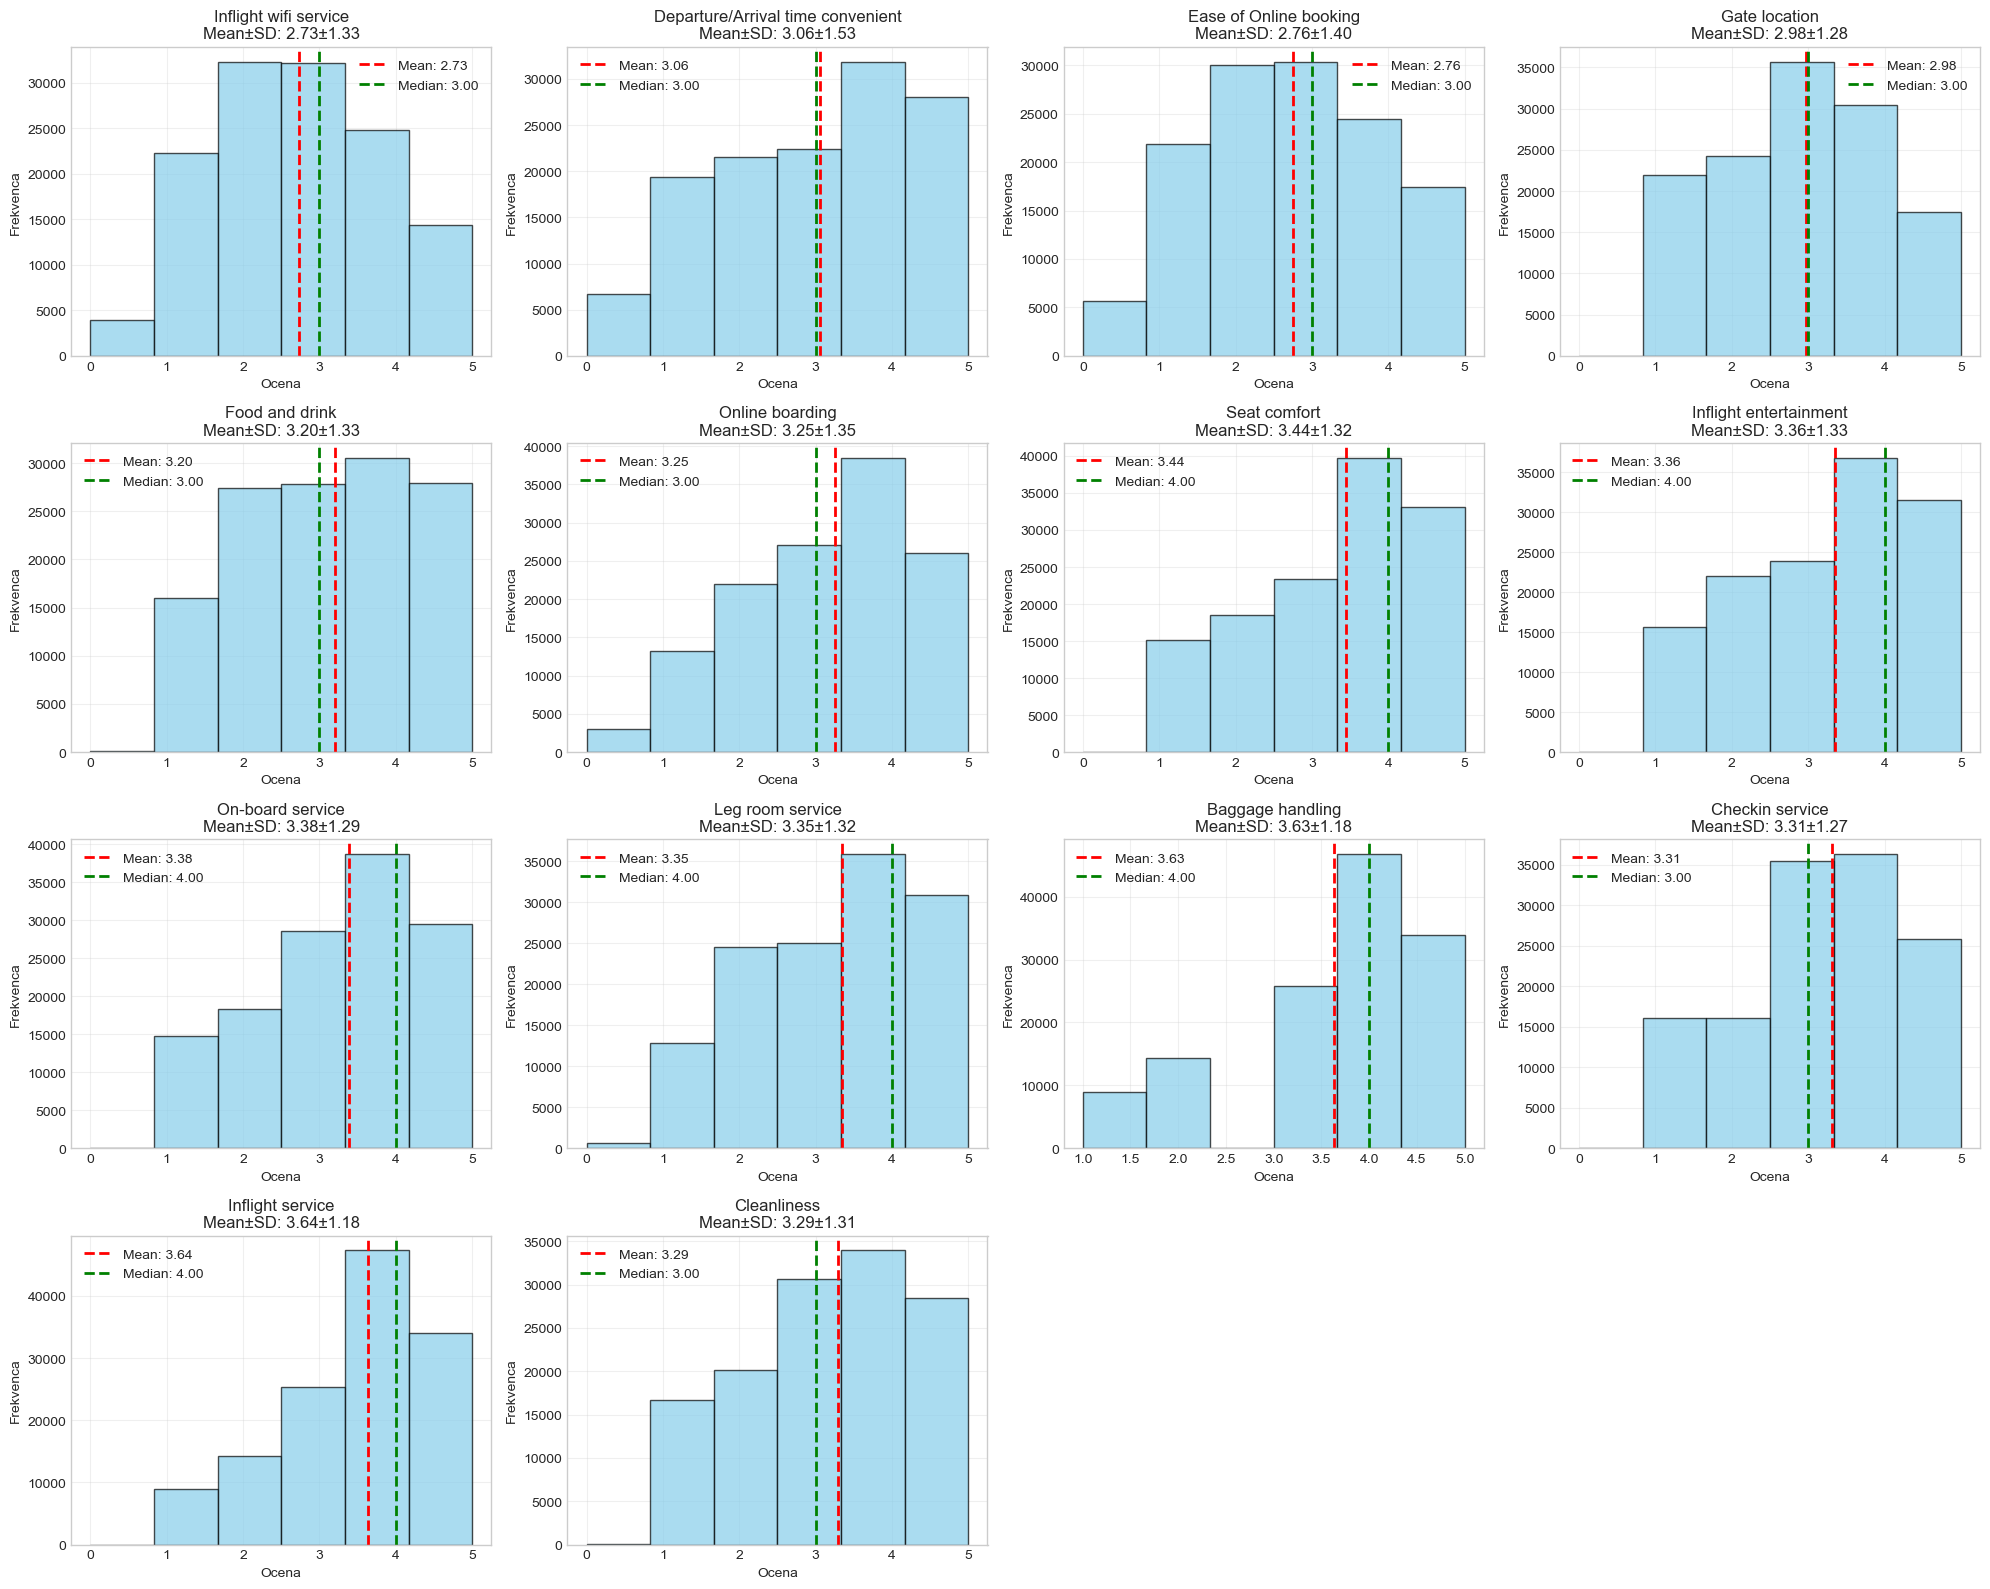

In [7]:
# 1. NUMERIČNE SPREMENLJIVKE - Histogrami

# Rating spremenljivke (0-5)
rating_cols = [col for col in numeric_cols if df[col].max() <= 5 and col not in 
               ['Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes', 'Flight_Distance', 'Age']]

if rating_cols:
    n_cols = 4
    n_rows = int(np.ceil(len(rating_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for idx, col in enumerate(rating_cols):
        ax = axes[idx]
        data = df[col].dropna()
        
        # Histogram
        ax.hist(data, bins=6, edgecolor='black', alpha=0.7, color='skyblue')
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
        ax.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
        
        ax.set_xlabel('Ocena')
        ax.set_ylabel('Frekvenca')
        ax.set_title(f'{col}\nMean±SD: {data.mean():.2f}±{data.std():.2f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Skrij prazne subplote
    for idx in range(len(rating_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

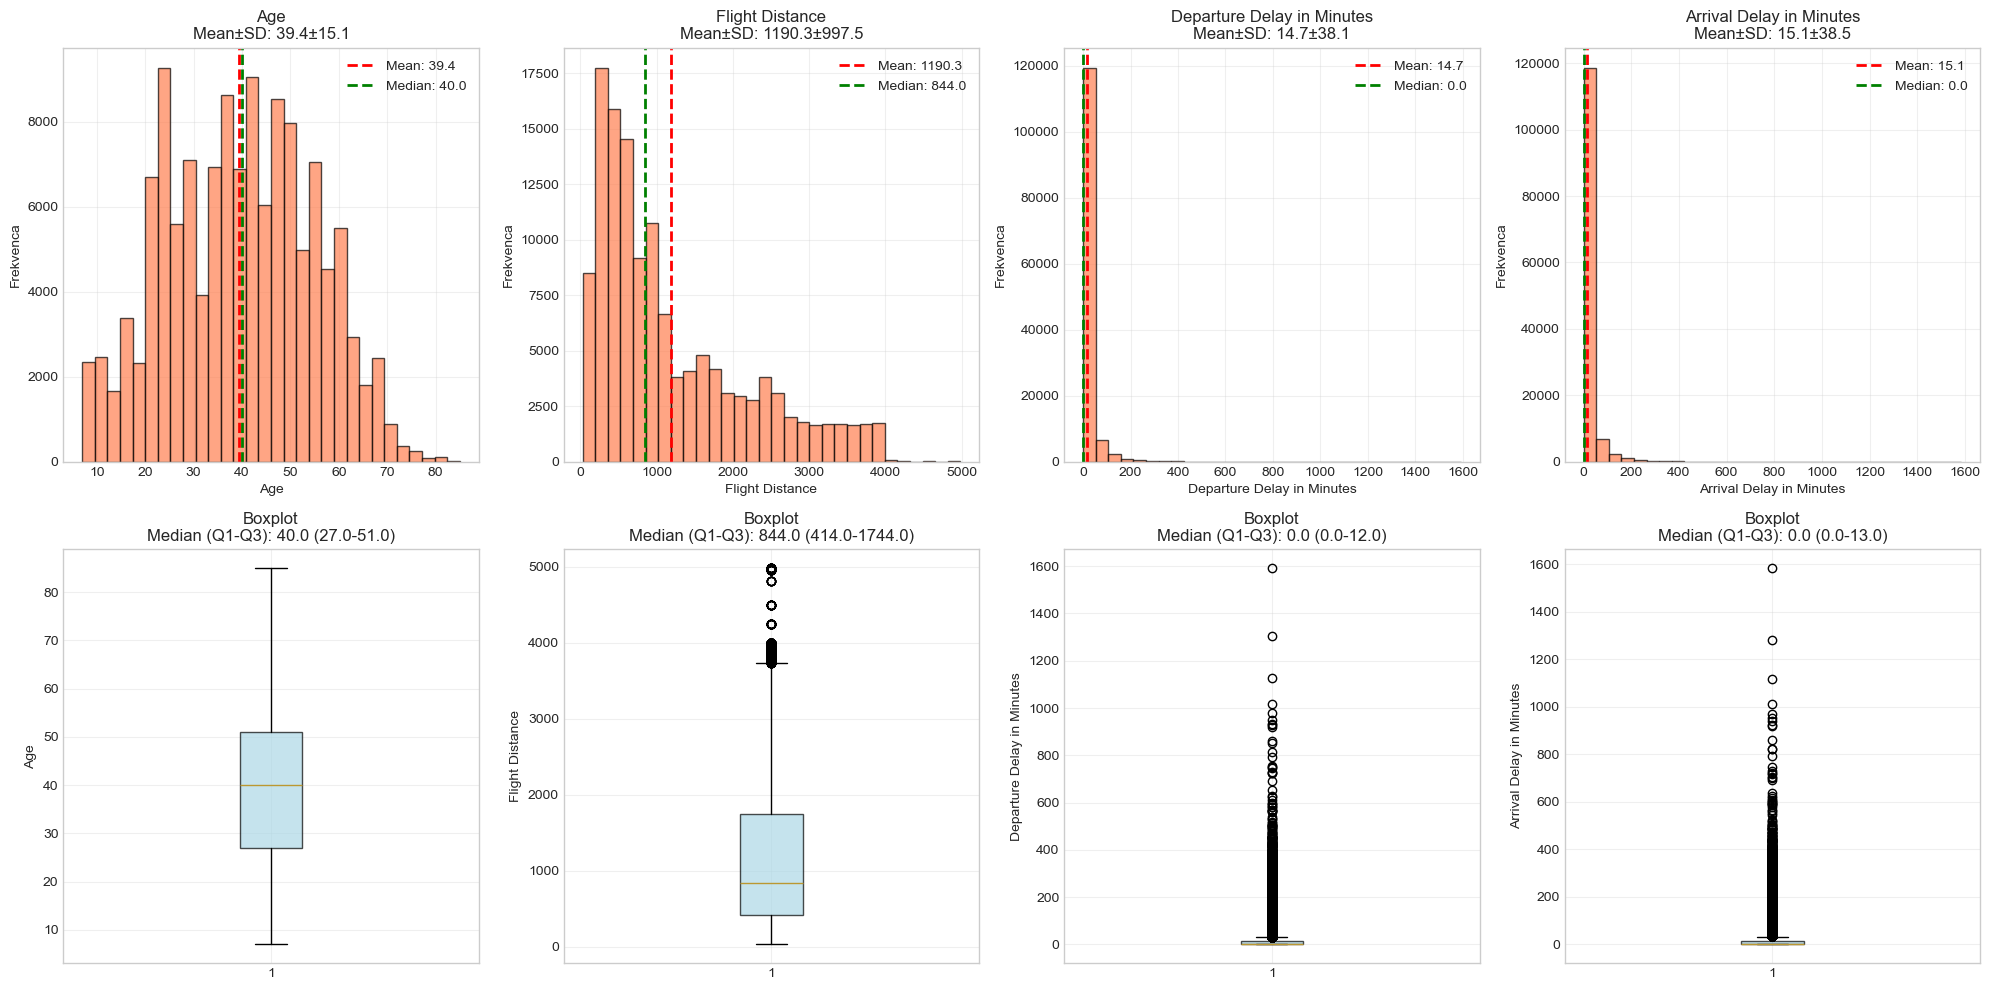

In [8]:
# 2. Kontinuirane spremenljivke - Histogrami + Boxploti
continuous_vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, col in enumerate(continuous_vars):
    data = df[col].dropna()
    
    # Histogram
    ax1 = axes[0, idx]
    ax1.hist(data, bins=30, edgecolor='black', alpha=0.7, color='coral')
    ax1.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
    ax1.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frekvenca')
    ax1.set_title(f'{col}\nMean±SD: {data.mean():.1f}±{data.std():.1f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Boxplot
    ax2 = axes[1, idx]
    bp = ax2.boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax2.set_ylabel(col)
    ax2.set_title(f'Boxplot\nMedian (Q1-Q3): {data.median():.1f} ({data.quantile(0.25):.1f}-{data.quantile(0.75):.1f})')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

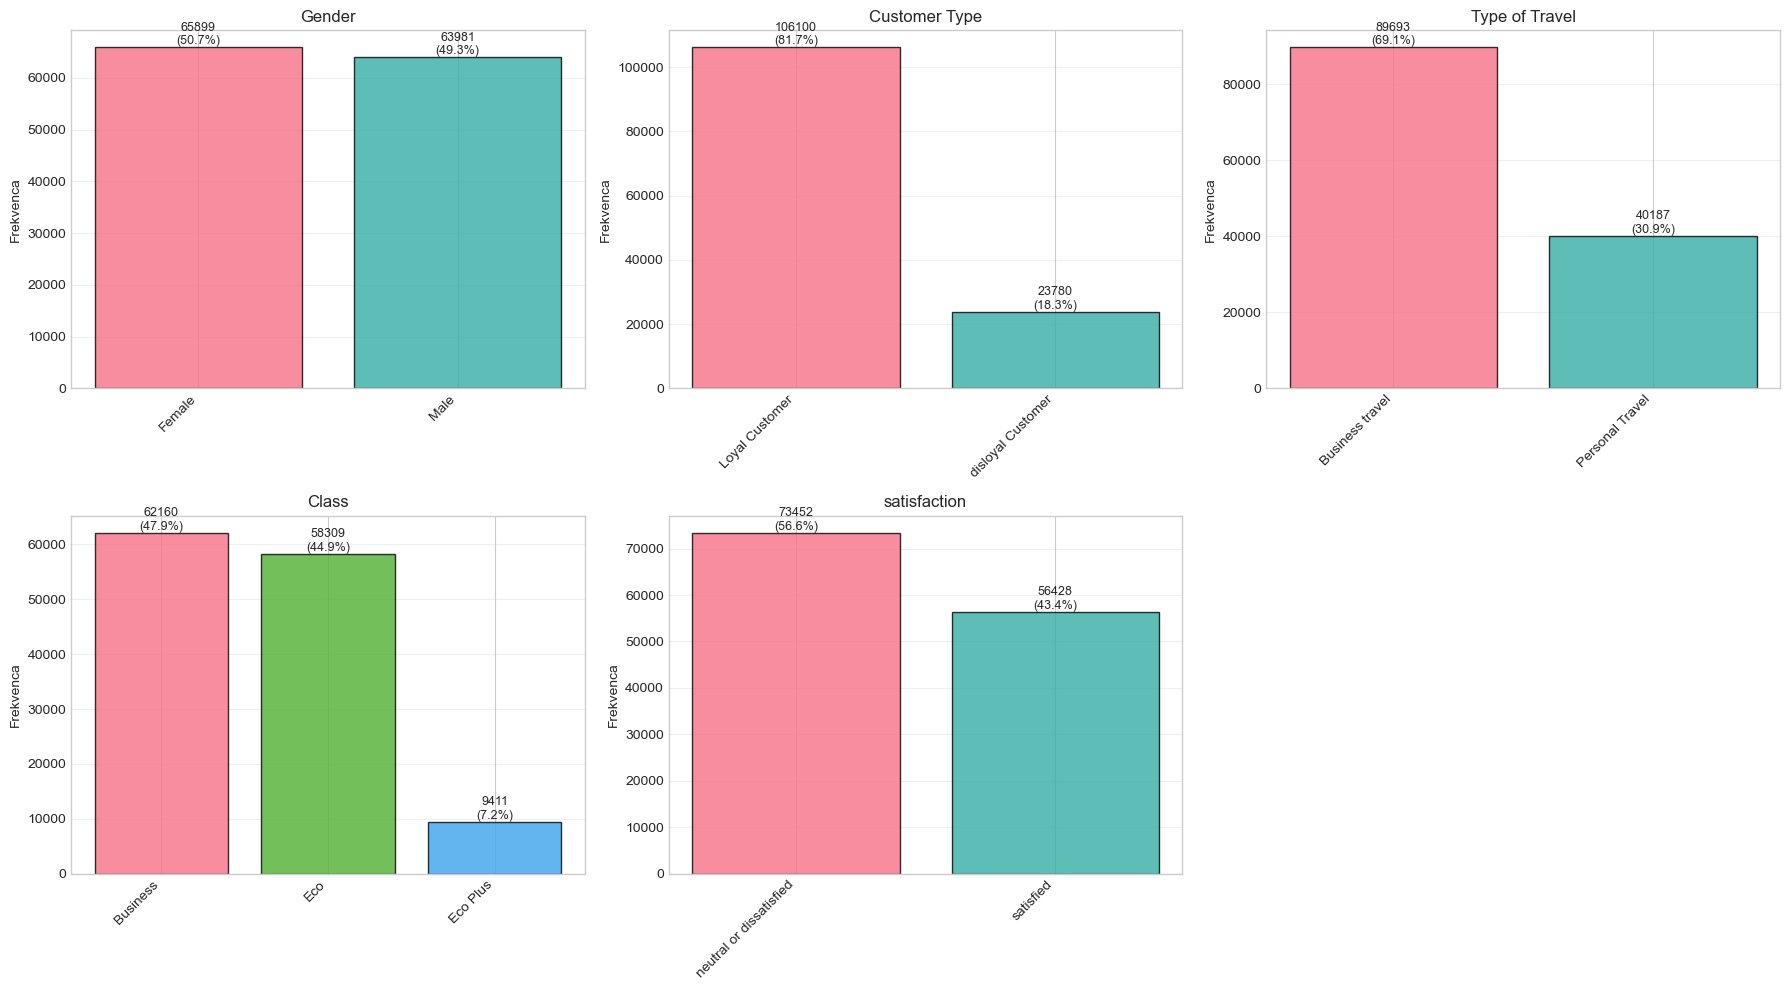

In [9]:
# 3. KATEGORIČNE SPREMENLJIVKE - Barploti
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    
    value_counts = df[col].value_counts()
    percentages = (value_counts / len(df) * 100).round(1)
    
    bars = ax.bar(range(len(value_counts)), value_counts.values, 
                   color=sns.color_palette("husl", len(value_counts)),
                   edgecolor='black', alpha=0.8)
    
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Frekvenca')
    ax.set_title(f'{col}')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Dodaj odstotke na stolpce
    for i, (bar, pct) in enumerate(zip(bars, percentages)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({pct}%)',
                ha='center', va='bottom', fontsize=9)

# Skrij prazne subplote
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

### Interpretacija

#### NUMERIČNE SPREMENLJIVKE

1. DEMOGRAFSKE KARAKTERISTIKE

Starost (Age)

    Povprečje: 39.38 ± 15.11 let

    Razpon: 7-85 let
    Opažanja:

    Širok spekter potnikov od otrok do starejših

    Skewness blizu 0 (-0.00) → skoraj popolnoma simetrična porazdelitev

    Negativna kurtosis (-0.72) → bolj ploščata porazdelitev od normalne

    Mediana (40) ≈ mean → potrjuje simetričnost

    Zaključek: Reprezentativen vzorec različnih starostnih skupin, brez izrazitih odstopanj


2. KARAKTERISTIKE LETA

Flight Distance

    Povprečje: 1189.45 ± 997.15 km

    Mediana: 843 km (nižja od povprečja!)

    Razpon: 31-4983 km

    Opažanja:

    Pozitivna skewness (1.11) → desno asimetrična porazdelitev

    Večina letov je krajših (Q3 = 1743 km), nekaj zelo dolgih letov dvigne povprečje

    Zaključek: Prevladujejo kratki do srednje dolgi leti, z manjšim deležem intercontinentalnih letov



Zamude

    Departure Delay: 14.82 ± 38.23 min (mediana = 0!)

    Arrival Delay: 15.18 ± 38.70 min (mediana = 0!)

    Opažanja:

    EKSTREMNO visoka skewness (6.73 in 6.60) → močno desno asimetrična

    EKSTREMNO visoka kurtosis (100.26 in 94.53) → prisotnost ekstremnih vrednosti

    Max zamude: 1592 min (26.5 ur!) in 1584 min

    50% letov odide in prispe brez zamude (mediana = 0)

    Q3 = 12-13 min → 75% letov ima zamudo < 15 min

    Zaključek: Večina letov je punktualnih, redke ekstremne zamude močno vplivajo na povprečje in variabilnost



3. OCENE STORITEV (0-5 lestvica)

Razdelitev po povprečnih ocenah:

    NAJVIŠJE OCENJENE STORITVE (≥ 3.6):

        Inflight service: 3.64 ± 1.18 (najboljša!)

        Baggage handling: 3.63 ± 1.18

        Seat comfort: 3.44 ± 1.32

        SREDNJE OCENJENE (3.2-3.4):

        On-board service: 3.38 ± 1.29

        Inflight entertainment: 3.36 ± 1.33

        Leg room service: 3.35 ± 1.32

        Checkin service: 3.30 ± 1.27

        Cleanliness: 3.29 ± 1.31

        Online boarding: 3.25 ± 1.35

        Food and drink: 3.20 ± 1.33

    NAJNIŽJE OCENJENE (< 3.1):

        Departure/Arrival time convenient: 3.06 ± 1.53

        Gate location: 2.98 ± 1.28

        Ease of Online booking: 2.76 ± 1.40

        Inflight wifi service: 2.73 ± 1.33 (najslabša!)

Ključna opažanja pri ocenah:

    Negativna skewness pri večini storitev → več višjih kot nižjih ocen

    Negativna kurtosis → ocene so dokaj enakomerno razporejene po lestvici

    Največja variabilnost (SD > 1.4): Departure/Arrival time convenient, Ease of Online booking

    Najmanjša variabilnost (SD < 1.2): Baggage handling, Inflight service

    Nobena storitev NI ocenjena odlično (vse < 3.7)

    WiFi je največja šibka točka letalske družbe

#### KATEGORIČNE SPREMENLJIVKE

1. DEMOGRAFSKA STRUKTURA

Gender

    Skoraj popolnoma uravnoteženo: 50.7% ženske, 49.3% moški

    Odličen vzorec za analizo brez gender bias

    Customer Type

    81.7% Loyal Customers vs 18.3% disloyal

    Pomembno: Velika večina so zvesti/redni potniki

    To lahko vpliva na pričakovanja in ocene storitev

    Lojalnost ne pomeni nujno zadovoljstva!

2. TIP POTOVANJA

Type of Travel

    69.0% Business travel vs 31.0% Personal

    Ključno spoznanje: Poslovni potniki so primarna ciljna skupina

    Različna pričakovanja: business potniki bolj zahtevni glede WiFi, časa, udobja

Class

    Business: 47.8%

    Economy: 45.0%

    Economy Plus: 7.2%

    Skoraj enakomerna porazdelitev med Business in Eco

    Eco Plus je niša produkt

3. CILJNA SPREMENLJIVKA - ZADOVOLJSTVO

Satisfaction

    56.7% nezadovoljnih (neutral or dissatisfied)

    43.3% zadovoljnih

    KRITIČNO: Več kot polovica potnikov ni zadovoljna!

    To predstavlja velik prostor za izboljšave

## Bivariantna analiza

In [8]:
# Priprava seznama za rezultate
bivariate_results = []

# Definiramo numerične in kategorične stolpce (brez ciljne spremenljivke)
target = 'satisfaction'
if 'id' in numeric_cols: numeric_cols.remove('id')
if 'Unnamed: 0' in numeric_cols: numeric_cols.remove('Unnamed: 0')


if target in categorical_cols: categorical_cols.remove(target)

In [11]:
# 1. ANALIZA ZA NUMERIČNE SPREMENLJIVKE (t-test)
for col in numeric_cols:
    # Priprava skupin
    g_sat = df[df[target] == 'satisfied'][col].dropna()
    g_unsat = df[df[target] != 'satisfied'][col].dropna()
    
    # 1. Preverjanje normalnosti (zaradi velikega vzorca uporabimo D'Agostino-Pearson)
    # Shapiro-Wilk ni zanesljiv nad 5000 vzorci
    _, p_norm1 = normaltest(g_sat)
    _, p_norm2 = normaltest(g_unsat)
    is_normal = (p_norm1 > 0.001) and (p_norm2 > 0.001)
    
    test_used = ""
    p_val = 0
    stat = 0
    
    if not is_normal:
        # Neparametrični test
        stat, p_val = mannwhitneyu(g_sat, g_unsat)
        test_used = "Mann-Whitney U"
    else:
        # 2. Preverjanje enakosti varianc (Levene)
        _, p_levene = levene(g_sat, g_unsat)
        
        if p_levene > 0.05:
            stat, p_val = ttest_ind(g_sat, g_unsat, equal_var=True)
            test_used = "Student t-test"
        else:
            stat, p_val = ttest_ind(g_sat, g_unsat, equal_var=False)
            test_used = "Welch t-test"
    
    bivariate_results.append({
        'Spremenljivka': col,
        'Normalnost (p)': f"{min(p_norm1, p_norm2):.4f}" if is_normal else "p < 0.001",
        'Tip testa': test_used,
        'Statistika': round(stat, 3),
        'p-vrednost': round(p_val, 4) if p_val > 0.05 else "p < 0.05",
        'Interpretacija': 'Statistično značilno' if p_val < 0.05 else 'Ni značilno'
    })

# 2. ANALIZA ZA KATEGORIČNE SPREMENLJIVKE (Hi-kvadrat)
for col in categorical_cols:
    contingency = pd.crosstab(df[col], df['satisfaction'])
    # Izračun hi-kvadrat in pričakovanih frekvenc
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    
    # Preverjanje pogoja: vse pričakovane frekvence >= 5
    min_expected = expected.min()
    
    if min_expected < 5:
        # Če je tabela 2x2, uporabimo Yatesovo korekcijo (v scipy je to correction=True)
        # correction=True se privzeto izvaja pri chi2_contingency za 2x2 tabele
        test_used = "Hi-kvadrat (Yates kor.)"
        chi2, p, dof, expected = stats.chi2_contingency(contingency, correction=True)
    else:
        test_used = "Hi-kvadrat"
        chi2, p, dof, expected = stats.chi2_contingency(contingency, correction=False)
        
    bivariate_results.append({
        'Spremenljivka': col,
        'Tip testa': test_used,
        'Statistika': round(chi2, 3),
        'p-vrednost': round(p, 4) if p > 0.05 else "p < 0.05",
        'Interpretacija': 'Statistično značilno' if p < 0.05 else 'Ni značilno'
    })

# Ustvarjanje skupne tabele
bivariate_df = pd.DataFrame(bivariate_results)
display(bivariate_df)

,Spremenljivka,Normalnost (p),Tip testa,Statistika,p-vrednost,Interpretacija
0,Age,p < 0.001,Mann-Whitney U,2.419402e+09,p < 0.05,Statistično značilno
1,Flight Distance,p < 0.001,Mann-Whitney U,2.691604e+09,p < 0.05,Statistično značilno
2,Inflight wifi service,p < 0.001,Mann-Whitney U,2.749286e+09,p < 0.05,Statistično značilno
3,Departure/Arrival time convenient,p < 0.001,Mann-Whitney U,1.948951e+09,p < 0.05,Statistično značilno
4,Ease of Online booking,p < 0.001,Mann-Whitney U,2.485107e+09,p < 0.05,Statistično značilno
5,Gate location,p < 0.001,Mann-Whitney U,2.064161e+09,0.2089,Ni značilno
6,Food and drink,p < 0.001,Mann-Whitney U,2.564447e+09,p < 0.05,Statistično značilno
7,Online boarding,p < 0.001,Mann-Whitney U,3.365886e+09,p < 0.05,Statistično značilno
8,Seat comfort,p < 0.001,Mann-Whitney U,2.920407e+09,p < 0.05,Statistično značilno
9,Inflight entertainment,p < 0.001,Mann-Whitney U,3.012884e+09,p < 0.05,Statistično značilno


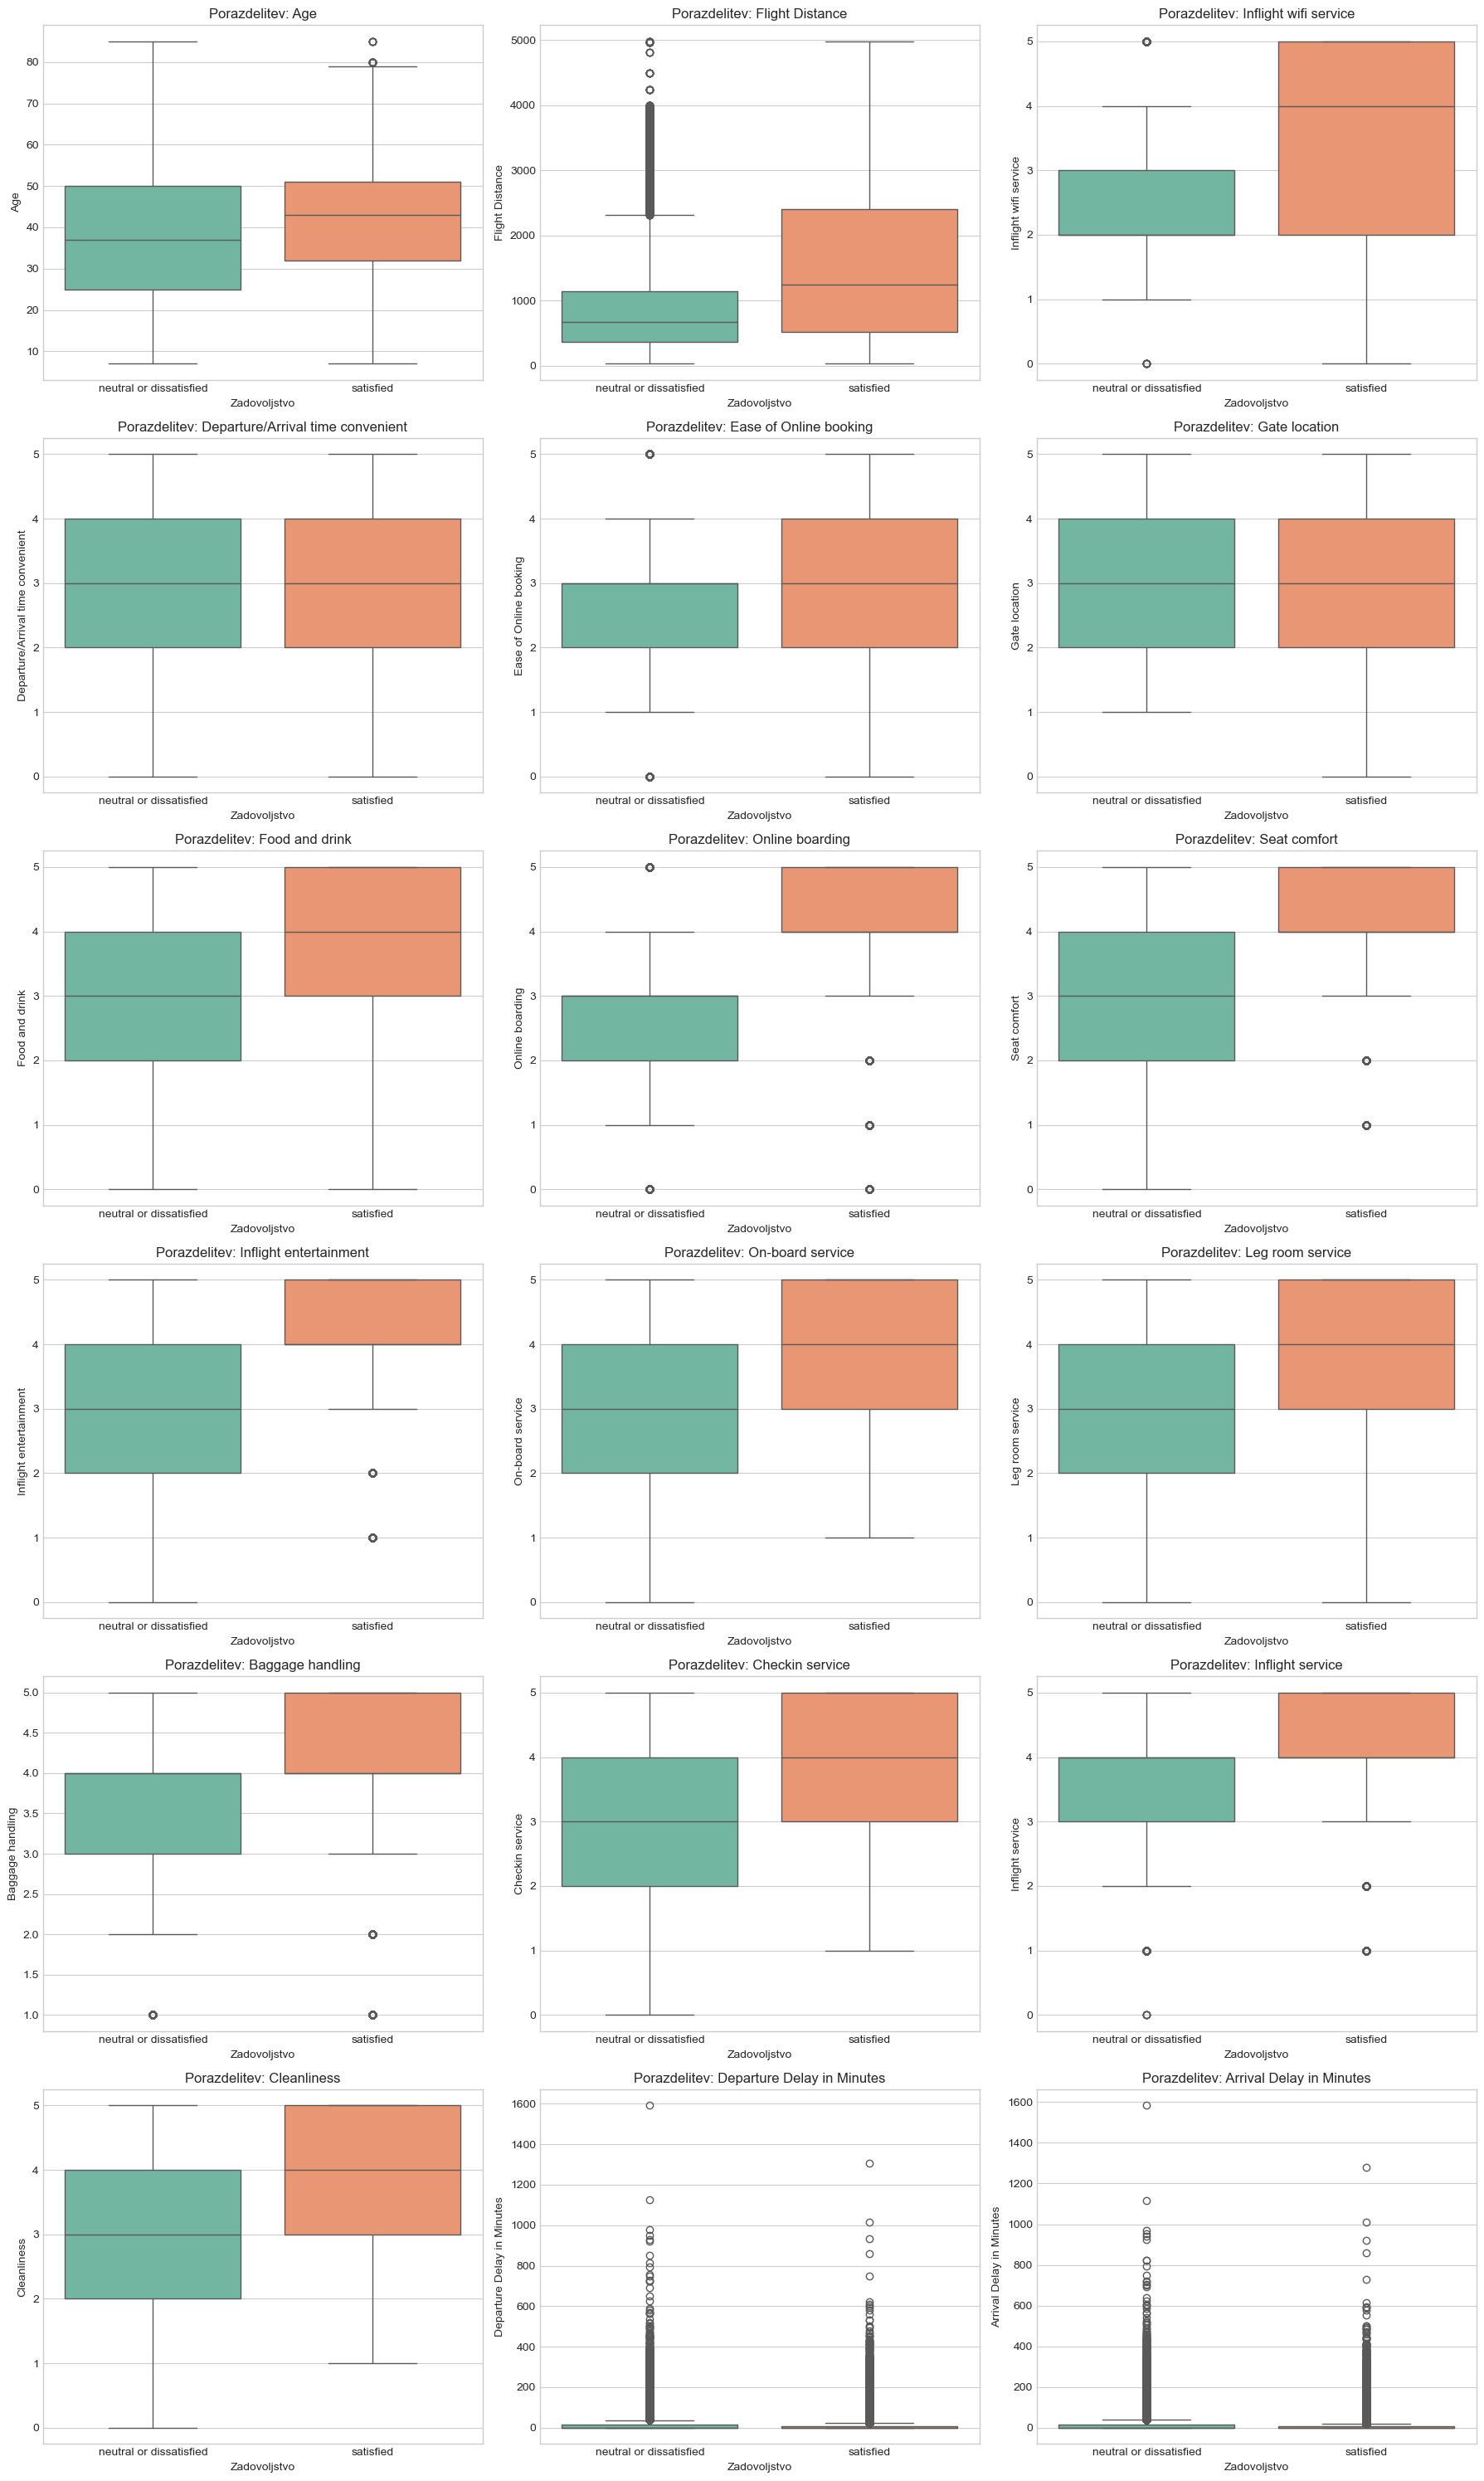

In [12]:
df = df.reset_index(drop=True)

n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

plt.figure(figsize=(18, n_rows * 5)) # Višina se prilagodi številu vrstic

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df, x='satisfaction', y=col, palette='Set2')
    plt.title(f'Porazdelitev: {col}')
    plt.xlabel('Zadovoljstvo')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

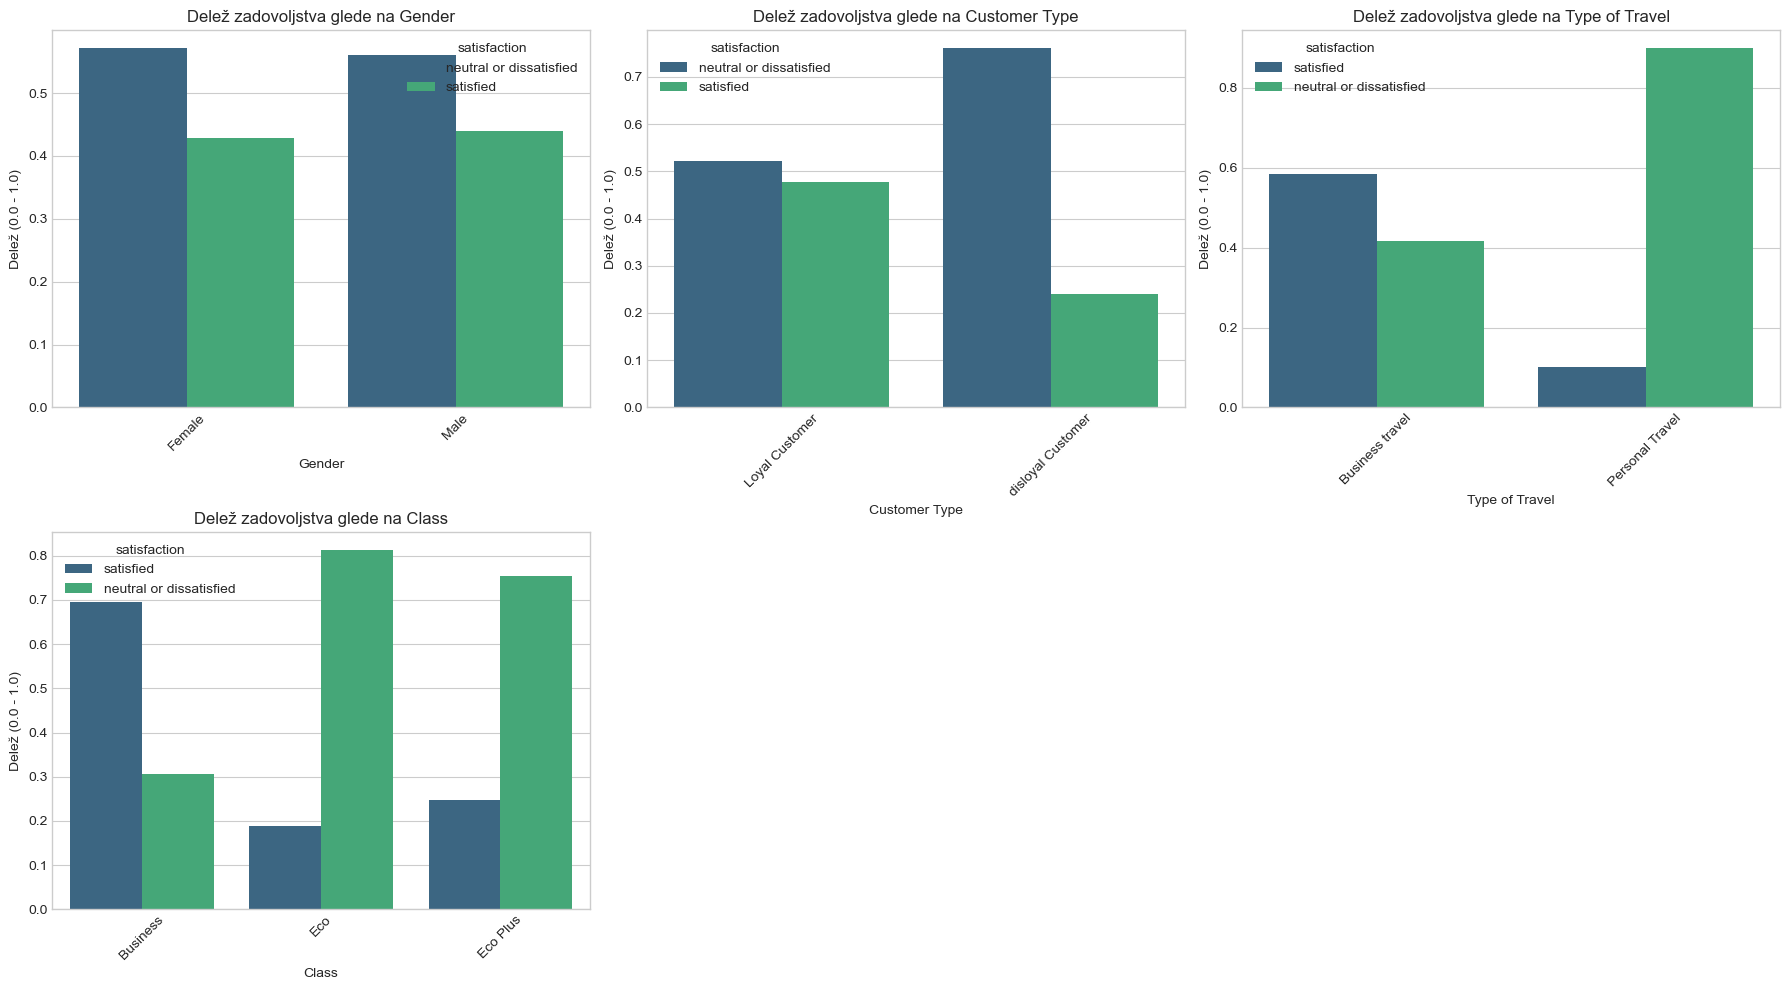

In [13]:
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

plt.figure(figsize=(18, n_rows * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    # Prikaz deleža (normalize) za boljšo interpretacijo
    df_pct = df.groupby(col)['satisfaction'].value_counts(normalize=True).rename('percentage').reset_index()
    sns.barplot(data=df_pct, x=col, y='percentage', hue='satisfaction', palette='viridis')
    plt.title(f'Delež zadovoljstva glede na {col}')
    plt.ylabel('Delež (0.0 - 1.0)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Klasifikacija

## Izbor spremenljivk

Top 20 najpomembnejših spremenljivk:
1. Online boarding (0.1638)
2. Inflight wifi service (0.1409)
3. Type of Travel_Personal Travel (0.1156)
4. Class_Eco (0.0696)
5. Inflight entertainment (0.0530)
6. Seat comfort (0.0493)
7. Customer Type_disloyal Customer (0.0401)
8. Ease of Online booking (0.0400)
9. Leg room service (0.0395)
10. Flight Distance (0.0387)
11. On-board service (0.0345)
12. Age (0.0340)
13. Baggage handling (0.0271)
14. Cleanliness (0.0270)
15. Checkin service (0.0249)
16. Inflight service (0.0220)
17. Departure/Arrival time convenient (0.0181)
18. Gate location (0.0153)
19. Food and drink (0.0124)
20. Arrival Delay in Minutes (0.0123)


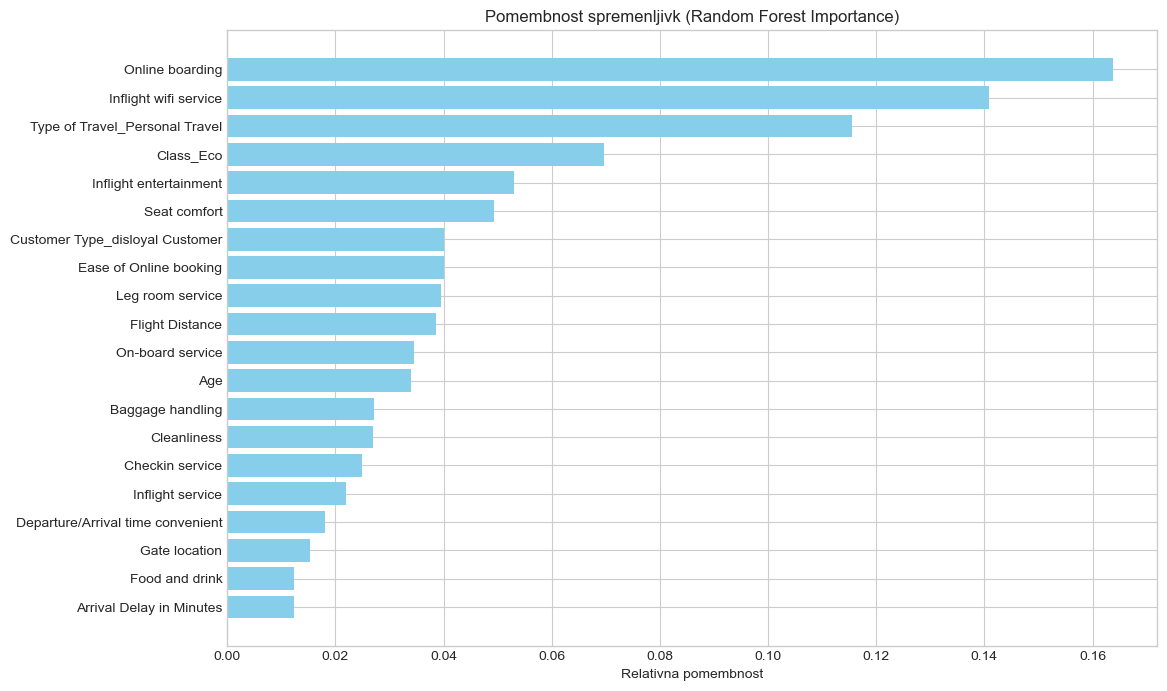

In [9]:
# 1. Priprava podatkov (Preprocessing)
# Odstranimo nepotrebne stolpce (npr. 'id' ali 'Unnamed: 0', če obstajata)
X = df.drop(['satisfaction'], axis=1)
if 'id' in X.columns: X = X.drop('id', axis=1)
if 'Unnamed: 0' in X.columns: X = X.drop('Unnamed: 0', axis=1)

# Pretvorba kategoričnih spremenljivk v 'dummy' spremenljivke (0 in 1)
X = pd.get_dummies(X, drop_first=True)

# Reševanje manjkajočih vrednosti (pomembno za Random Forest)
X = X.fillna(X.median())

y = df['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

# 2. Treniranje modela Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. Pridobivanje pomembnosti spremenljivk
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# 4. Izpis top 20 spremenljivk v tabeli
print("Top 20 najpomembnejših spremenljivk:")
for i in range(20):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

# 5. Grafični prikaz
plt.figure(figsize=(12, 8))
plt.title("Pomembnost spremenljivk (Random Forest Importance)")
plt.barh(range(len(indices[:20])), importances[indices[:20]], align="center", color='skyblue')
plt.yticks(range(len(indices[:20])), [features[i] for i in indices[:20]])
plt.xlabel("Relativna pomembnost")
plt.gca().invert_yaxis()
plt.show()

## Gradnja modelov

In [10]:
X1 = df_train.drop(['satisfaction'], axis=1)
if 'id' in X1.columns: X1 = X1.drop('id', axis=1)
if 'Unnamed: 0' in X1.columns: X1 = X1.drop('Unnamed: 0', axis=1)

In [11]:
# Pretvorba kategoričnih spremenljivk v 'dummy' spremenljivke (0 in 1)
X1 = pd.get_dummies(X1, drop_first=True)

# Reševanje manjkajočih vrednosti (pomembno za Random Forest)
X1 = X1.fillna(X1.median())

y1 = df_train['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

In [12]:
X_test = df_test.drop(['satisfaction'], axis=1)
if 'id' in X_test.columns: X_test = X_test.drop('id', axis=1)
if 'Unnamed: 0' in X_test.columns: X_test = X_test.drop('Unnamed: 0', axis=1)

In [13]:
# Pretvorba kategoričnih spremenljivk v 'dummy' spremenljivke (0 in 1)
X_test = pd.get_dummies(X_test, drop_first=True)

# Reševanje manjkajočih vrednosti (pomembno za Random Forest)
X_test = X_test.fillna(X_test.median())

y_test = df_test['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

In [14]:
# DEFINICIJA POSEBNIH METRIK
def get_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def get_npv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fn) if (tn + fn) > 0 else 0

scoring_metrics = {
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'Sensitivity': 'recall',
    'Specificity': make_scorer(get_specificity),
    'PPV': 'precision',
    'NPV': make_scorer(get_npv),
    'F1': 'f1'
}

In [15]:
# 1. PRIPRAVA PODATKOV
# X1, y1 = tvoja učna množica (train)
# X_test, y_test = tvoja validacijska množica (test)
# top_15_features = seznam tvojih izbranih spremenljivk
top_15_features = [
    'Online boarding', 'Inflight wifi service', 'Inflight entertainment', 
    'Seat comfort', 'Flight Distance', 'Leg room service', 
    'Ease of Online booking', 'Age', 'On-board service', 'Baggage handling', 
    'Cleanliness', 'Checkin service', 'Customer Type_disloyal Customer', 
    'Type of Travel_Personal Travel', 'Class_Eco'
]

X_train_final = X1[top_15_features].fillna(X1[top_15_features].median()).reset_index(drop=True)
y_train_final = y1.reset_index(drop=True)
X_test_final = X_test[top_15_features].fillna(X_test[top_15_features].median()).reset_index(drop=True)
y_test_final = y_test.reset_index(drop=True)

### Izbira hiperparametrov

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# GB
param_dist = {
    'learning_rate': np.arange(0.01, 0.2, 0.01), 
    'n_estimators': [100, 200, 300, 400],  
    'max_depth': [3, 5, 7, 9],  
}

gb_model = GradientBoostingClassifier()

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

random_search.fit(X_train_final, y_train_final)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [26]:
y_pred_best = best_model.predict(X_test_final)

accuracy_best = accuracy_score(y_test_final, y_pred_best)

print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

Best Parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': np.float64(0.09999999999999999)}
Best Model Accuracy: 0.9586926393594087


In [28]:
# RF
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_model = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

random_search.fit(X_train_final, y_train_final)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_test_final)

accuracy_best = accuracy_score(y_test_final, y_pred_best)

print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Best Model Accuracy: 0.9583076686171851


In [29]:
from sklearn.linear_model import LogisticRegression

# Parametri za LR
param_dist_lr = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'saga'],  # 'liblinear' je super za majhne, 'saga' za velike baze
    'clf__penalty': ['l1', 'l2']
}

# Pipeline je nujen zaradi StandardScalerja
lr_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

random_search_lr = RandomizedSearchCV(lr_pipe, param_dist_lr, n_iter=10, cv=5, n_jobs=-1)
random_search_lr.fit(X_train_final, y_train_final)
print("Best LR Params:", random_search_lr.best_params_)

Best LR Params: {'clf__solver': 'saga', 'clf__penalty': 'l1', 'clf__C': 0.01}


In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Parametri za KNN
param_dist_knn = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan']
}

knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', KNeighborsClassifier())
])

random_search_knn = RandomizedSearchCV(knn_pipe, param_dist_knn, n_iter=10, cv=5, n_jobs=-1)
random_search_knn.fit(X_train_final, y_train_final)
print("Best KNN Params:", random_search_knn.best_params_)

Best KNN Params: {'clf__weights': 'uniform', 'clf__n_neighbors': 11, 'clf__metric': 'manhattan'}


In [30]:
from sklearn.svm import LinearSVC

# Parametri za LinearSVM
param_dist_svm = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10],
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__max_iter': [2000, 5000]
}

svm_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

random_search_svm = RandomizedSearchCV(svm_pipe, param_dist_svm, n_iter=10, cv=5, n_jobs=-1)
random_search_svm.fit(X_train_final, y_train_final)
print("Best SVM Params:", random_search_svm.best_params_)

Best SVM Params: {'clf__max_iter': 5000, 'clf__loss': 'hinge', 'clf__C': 1}


### Prikaz regresijskega modela

In [ ]:
import statsmodels.api as sm

# 1. Pretvorba bool stolpcev v int (0/1)
# To bo popravilo 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel' in 'Class_Eco'
X_train_final_fixed = X_train_final.copy()
bool_cols = X_train_final_fixed.select_dtypes(include=['bool']).columns
X_train_final_fixed[bool_cols] = X_train_final_fixed[bool_cols].astype(int)

# 2. Dodajanje konstante
X_train_sm = sm.add_constant(X_train_final_fixed)

# 3. Zaženemo model (y_train_final je že int64, kar je v redu)
sm_model = sm.Logit(y_train_final, X_train_sm)
result = sm_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.339859
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103888
Method:                           MLE   Df Model:                           15
Date:                Mon, 12 Jan 2026   Pseudo R-squ.:                  0.5033
Time:                        17:34:53   Log-Likelihood:                -35313.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -6.1518      0.067    -91.958  

$$\begin{aligned}
L = \ln\left(\frac{P}{1-P}\right) = &-6.1518 \\
&+ 0.6363 \cdot (\text{Online boarding}) \\
&+ 0.3611 \cdot (\text{Inflight wifi service}) \\
&+ 0.0970 \cdot (\text{Inflight entertainment}) \\
&+ 0.0556 \cdot (\text{Seat comfort}) \\
&+ 0.00003581 \cdot (\text{Flight Distance}) \\
&+ 0.2649 \cdot (\text{Leg room service}) \\
&- 0.1859 \cdot (\text{Ease of Online booking}) \\
&- 0.0085 \cdot (\text{Age}) \\
&+ 0.3372 \cdot (\text{On-board service}) \\
&+ 0.1792 \cdot (\text{Baggage handling}) \\
&+ 0.1816 \cdot (\text{Cleanliness}) \\
&+ 0.3302 \cdot (\text{Checkin service}) \\
&- 1.8983 \cdot (\text{Customer Type\_disloyal Customer}) \\
&- 2.9013 \cdot (\text{Type of Travel\_Personal Travel}) \\
&- 0.5498 \cdot (\text{Class\_Eco})
\end{aligned}$$

### Gradnja modelov

In [ ]:
# DEFINICIJA MODELOV

kf = KFold(n_splits=10, shuffle=True, random_state=42)
models = []

models = []

# 1. Logistic Regression (LR)
models.append(('LR', Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(C=0.01, solver='saga', penalty='l1', random_state=42, max_iter=1000))
])))

# 2. Random Forest (RF)
models.append(('RF', RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=2, 
    min_samples_leaf=4, 
    random_state=42
)))

# 3. Gradient Boosting (GB)
models.append(('GB', GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=9, 
    learning_rate=0.1,
    random_state=42
)))

# 4. K-Nearest Neighbors (KNN)
models.append(('KNN', Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan'))
])))

# 5. Linear SVM
models.append(('LinearSVM', Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LinearSVC(C=1, loss='hinge', max_iter=5000, random_state=42))
])))

### Izvedba evalvacije

Začenjam proces evalvacije...
Obdelujem model: LR
Obdelujem model: RF
Obdelujem model: GB
Obdelujem model: KNN
Obdelujem model: LinearSVM

TABELA ZA SEMINARSKO NALOGO:


,Model,Parametri,CV_Accuracy (Mean±SD),CV_AUC (Mean±SD),Test_Accuracy,Test_AUC,Test_Sens,Test_Spec,Test_PPV,Test_NPV,Test_F1
0,LR,"{'C': 0.01, 'class_weight': None, 'dual': Fals...",0.8720 ± 0.0029,0.9244 ± 0.0023,0.8690,0.9229,0.8313,0.8985,0.8650,0.8719,0.8478
1,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.9434 ± 0.0019,0.9884 ± 0.0007,0.9442,0.9883,0.9299,0.9553,0.9422,0.9457,0.9360
2,GB,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.9590 ± 0.0028,0.9935 ± 0.0006,0.9587,0.9936,0.9365,0.9761,0.9684,0.9516,0.9522
3,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.9415 ± 0.0025,0.9830 ± 0.0014,0.9424,0.9839,0.9116,0.9664,0.9551,0.9332,0.9328
4,LinearSVM,"{'C': 1, 'class_weight': None, 'dual': 'auto',...",0.8735 ± 0.0031,0.9247 ± 0.0024,0.8705,0.9234,0.8218,0.9087,0.8756,0.8670,0.8479


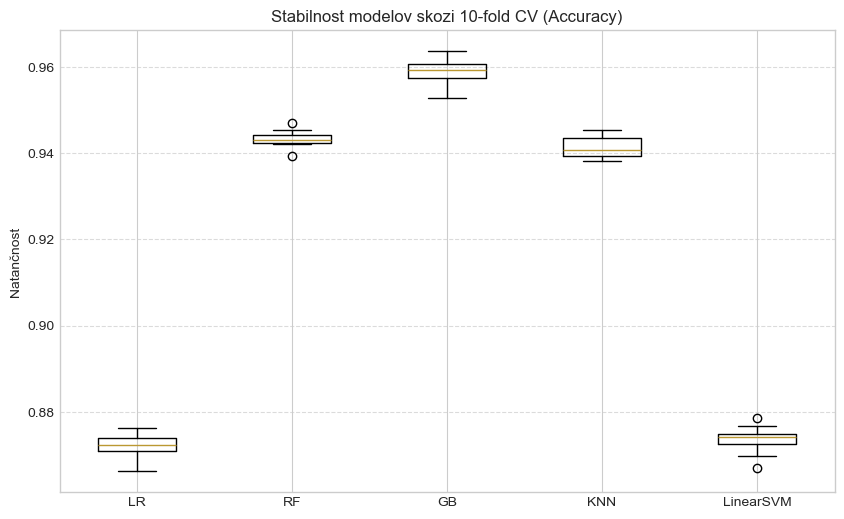

In [33]:
# 3. IZVEDBA EVALVACIJE
results_list = []
cv_raw_accuracy = []

print("Začenjam proces evalvacije...")

for name, model in models:
    print(f"Obdelujem model: {name}")
    
    # A) 10-fold CV na učni množici
    cv_results = cross_validate(model, X_train_final, y_train_final, cv=kf, scoring=scoring_metrics, n_jobs=-1)
    cv_raw_accuracy.append(cv_results['test_Accuracy'])
    
    # B) Evalvacija na testni (validacijski) množici
    model.fit(X_train_final, y_train_final)
    y_pred = model.predict(X_test_final)
    
    # Verjetnosti za AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_final)[:, 1]
    else:
        y_proba = model.decision_function(X_test_final)
    
    if hasattr(model, 'named_steps'):
        params_to_show = str(model.named_steps['clf'].get_params())
    else:
        params_to_show = str(model.get_params())

    res_entry = {
        'Model': name,
        'Parametri': params_to_show,
        'CV_Accuracy (Mean±SD)': f"{cv_results['test_Accuracy'].mean():.4f} ± {cv_results['test_Accuracy'].std():.4f}",
        'CV_AUC (Mean±SD)': f"{cv_results['test_AUC'].mean():.4f} ± {cv_results['test_AUC'].std():.4f}",
        'Test_Accuracy': round(accuracy_score(y_test_final, y_pred), 4),
        'Test_AUC': round(roc_auc_score(y_test_final, y_proba), 4),
        'Test_Sens': round(recall_score(y_test_final, y_pred), 4),
        'Test_Spec': round(get_specificity(y_test_final, y_pred), 4),
        'Test_PPV': round(precision_score(y_test_final, y_pred), 4),
        'Test_NPV': round(get_npv(y_test_final, y_pred), 4),
        'Test_F1': round(f1_score(y_test_final, y_pred), 4)
    }
    results_list.append(res_entry)

# 4. PRIKAZ REZULTATOV
df_table = pd.DataFrame(results_list)
print("\nTABELA ZA SEMINARSKO NALOGO:")
display(df_table)

# 5. GRAFIČNI PRIKAZ (Accuracy)
plt.figure(figsize=(10, 6))
plt.boxplot(cv_raw_accuracy, labels=[n for n, m in models])
plt.title('Stabilnost modelov skozi 10-fold CV (Accuracy)')
plt.ylabel('Natančnost')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Učenje treh najboljših modelov

In [34]:
final_models = []
final_models.append(models[1])
final_models.append(models[2])
final_models.append(models[3])

Treniram in shranjujem model: RF...
Treniram in shranjujem model: GB...
Treniram in shranjujem model: KNN...


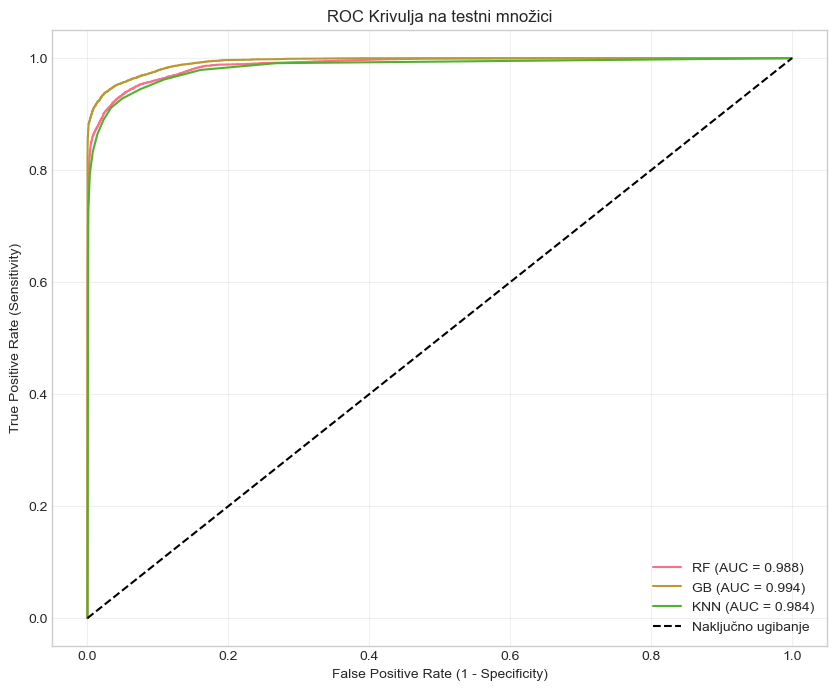

In [35]:
test_results = []
plt.figure(figsize=(10, 8)) # Za ROC krivulje

for name, model in final_models:
    print(f"Treniram in shranjujem model: {name}...")
    
    # Učenje na celotni učni množici
    model.fit(X_train_final, y_train_final)
    
    # Shranjevanje modela
    joblib.dump(model, f'classification_models/model_{name}.pkl')
    
    # Napovedovanje na testni množici
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]
    
    # Izračun vseh 7 metrik
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test_final, y_pred),
        'AUC': roc_auc_score(y_test_final, y_proba),
        'Sensitivity': recall_score(y_test_final, y_pred),
        'Specificity': get_specificity(y_test_final, y_pred),
        'PPV': precision_score(y_test_final, y_pred),
        'NPV': get_npv(y_test_final, y_pred),
        'F1': f1_score(y_test_final, y_pred)
    }
    test_results.append(metrics)
    
    # Priprava za ROC graf
    fpr, tpr, _ = roc_curve(y_test_final, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["AUC"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Naključno ugibanje')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Krivulja na testni množici')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


KONČNI REZULTATI NA TESTNI MNOŽICI:


,Model,Accuracy,AUC,Sensitivity,Specificity,PPV,NPV,F1
0,RF,0.944179,0.988281,0.929931,0.955328,0.942159,0.945724,0.936005
1,GB,0.958731,0.993631,0.936508,0.976120,0.968441,0.951569,0.952207
2,KNN,0.942370,0.983897,0.911602,0.966445,0.955072,0.933210,0.932831


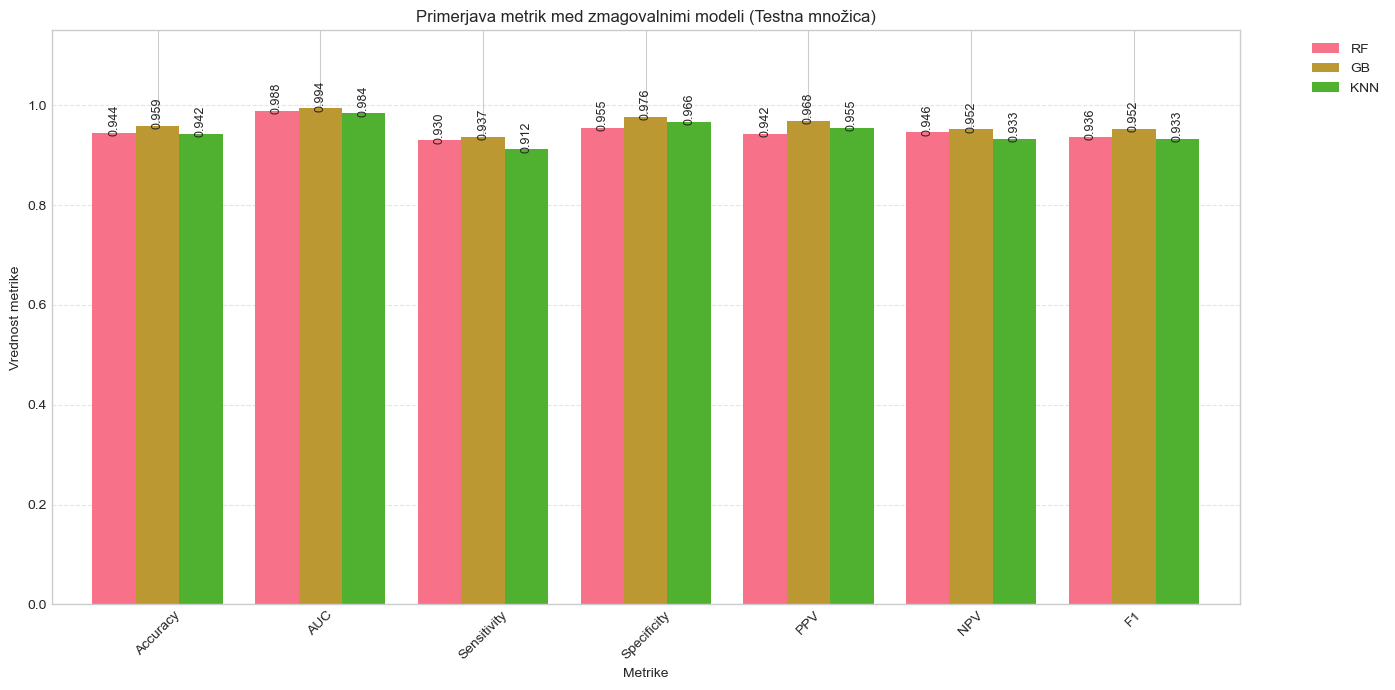

In [36]:
# 5. PRIKAZ KONČNE TABELE
df_final_test = pd.DataFrame(test_results)
print("\nKONČNI REZULTATI NA TESTNI MNOŽICI:")
display(df_final_test)

# 6. GRAFIČNI PRIKAZ METRIK (Bar Chart z vrednostmi) 
df_plot = df_final_test.set_index('Model').T
ax = df_plot.plot(kind='bar', figsize=(14, 7), width=0.8)

plt.title('Primerjava metrik med zmagovalnimi modeli (Testna množica)')
plt.ylabel('Vrednost metrike')
plt.xlabel('Metrike')
plt.xticks(rotation=45)
plt.ylim(0, 1.15)  # Povečamo zgornjo mejo, da bo prostor za številke
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Dodajanje številk nad stolpce
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=9,
                rotation=90) # Zaradi gostote stolpcev številke zasukamo navpično

plt.tight_layout()
plt.show()

## Povzetek ugotovitev in priporočila za vodstvo



### Izbira najboljšega modela

Na podlagi testiranja treh algoritmov (**Random Forest, Gradient Boosting in KNN**) smo za končno produkcijsko uporabo in simulacije izbrali model **Gradient Boosting**.

**Utemeljitev:**  
Model je dosegel najvišjo natančnost (**Accuracy**) in vrednost **AUC**, kar pomeni, da najbolje loči med zadovoljnimi in nezadovoljnimi potniki. Poleg tega je model robusten in odporen na šum v podatkih.

---

### Ključni dejavniki vpliva

Analiza pomembnosti spremenljivk (*Feature Importance*) je razkrila, da na zadovoljstvo potnikov najbolj vplivajo **digitalne storitve** in **fizično udobje**.

**Največji vpliv:**

- **Online boarding:** Najpomembnejši faktor – digitalna izkušnja pred poletom je ključna.
- **Inflight WiFi service:** Visoka korelacija z zadovoljstvom v moderni dobi.
- **Type of Travel (Personal):** Potniki na osebnih potovanjih so sistematično bolj kritični.
- **Inflight entertainment & Seat comfort:** Ključna faktorja fizične izkušnje.

**Smer vpliva (pozitiven / negativen):**

- **Pozitiven vpliv:**  
  Višje ocene storitev (WiFi, udobje sedežev, hrana) neposredno povečujejo verjetnost zadovoljstva.

- **Negativen vpliv:**  
  Ekonomska klasa (**Class_Eco**) in nezveste stranke (**disloyal Customer**) imajo izrazit negativen vpliv na verjetnost zadovoljstva. Prav tako osebna potovanja pogosto znižujejo povprečno oceno zadovoljstva v primerjavi s poslovnimi.

---

### Procesno smiselne spremembe

Na podlagi simulacij v aplikaciji smo ugotovili, da vlaganje v vse storitve hkrati ni stroškovno učinkovito. Smiselne so naslednje procesne prilagoditve:

- **Digitalizacija:**  
  Ker ima *Online boarding* največji vpliv, je smiselno proces prijave na let maksimalno poenostaviti (mobilna aplikacija).

- **Segmentacija:**  
  Namesto splošnega izboljševanja vseh letov se je treba osredotočiti na ekonomski razred na osebnih potovanjih, kjer so potniki najbolj kritični.

- **Minimalni standardi:**  
  Simulacije kažejo, da ocene pod **3** pri WiFi-ju in udobju sedežev drastično povečajo verjetnost nezadovoljstva. Zato je treba postaviti jasno spodnjo mejo kakovosti na teh področjih.

---

### Priporočila vodstvu

Vodstvu podjetja priporočamo naslednje strateške korake:

- **Prioritetna investicija v IT infrastrukturo:**  
  Izboljšanje sistema za spletno prijavo in stabilnosti WiFi omrežja na letalu. To so področja, kjer z najmanjšim vložkom dosežemo največji dvig zadovoljstva.

- **Nadgradnja sedežev v ekonomskem razredu:**  
  Udobje sedežev ostaja kritična točka. Priporočamo postopno posodobitev kabin v ekonomskem razredu, saj ta segment potnikov najbolj vpliva na povprečen ugled podjetja.

- **Program lojalnosti:**  
  Ker so *disloyal* stranke bistveno manj zadovoljne, je treba uvesti ukrepe za njihovo zadržanje. Lojalnost deluje kot »blažilec« pri manjših nevšečnostih med letom.

- **Uporaba razvite aplikacije:**  
  Priporočamo uporabo interaktivnega orodja za simulacije pred uvedbo večjih sprememb v storitvah, saj aplikacija z visoko zanesljivostjo napove odziv potnikov.


##  Testiranje globalnih sprememb in six sigma

In [16]:
model_GB = joblib.load('classification_models/model_GB.pkl')
model_RF = joblib.load('classification_models/model_RF.pkl')
model_KNN = joblib.load('classification_models/model_KNN.pkl')

loaded_models = []
loaded_models.append(('GB', model_GB))
loaded_models.append(('RF', model_RF))
loaded_models.append(('KNN', model_KNN))

In [17]:
def get_sigma_metrics(share_satisfied):
    # Error rate so nezadovoljni potniki (napake v procesu)
    error_rate = 1 - share_satisfied
    # DPMO - Defects Per Million Opportunities
    dpmo = error_rate * 1_000_000
    # Sigma nivo z vključenim 1.5 shiftom (standard v industriji)
    sigma = norm.ppf(1 - error_rate) + 1.5
    return dpmo, sigma

In [21]:
# 2. PRIPRAVA SIMULIRANIH PODATKOV (X_test_sim)
X_test_sim = X_test_final.copy()

# A: Popravek digitalnih storitev (samo za tiste, ki so jih uporabljali, ocena > 0)
X_test_sim.loc[(X_test_sim['Online boarding'] > 0) & (X_test_sim['Online boarding'] <= 2), 'Online boarding'] = 4
X_test_sim.loc[(X_test_sim['Inflight wifi service'] > 0) & (X_test_sim['Inflight wifi service'] <= 2), 'Inflight wifi service'] = 3

np.random.seed(42)
# B: Nadgradnja udobja v ekonomskem razredu (40% flote)
eco_indices = X_test_sim[X_test_sim['Class_Eco'] == 1].index
n_upgrade = int(len(eco_indices) * 0.40)
upgrade_indices = np.random.choice(eco_indices, size=n_upgrade, replace=False)
X_test_sim.loc[upgrade_indices, 'Seat comfort'] = (X_test_sim.loc[upgrade_indices, 'Seat comfort'] + 2).clip(upper=5)

# 3. IZVEDBA TESTOV ZA VSE MODELE
simulation_results = []
six_sigma_results = []

for name, model in loaded_models:
    # Izračun verjetnosti za t-test
    prob_before = model.predict_proba(X_test_final)[:, 1]
    prob_after = model.predict_proba(X_test_sim)[:, 1]
    
    # Paired t-test
    _, p_val = stats.ttest_rel(prob_after, prob_before)
    
    # Izračun deleža zadovoljnih (razred 1)
    share_before = (model.predict(X_test_final) == 1).mean()
    share_after = (model.predict(X_test_sim) == 1).mean()

    diff = share_after - share_before
    
    simulation_results.append({
        'Model': name,
        'Delež Prej': share_before,
        'Delež Po': share_after,
        'Razlika': diff,
        'P-val': "  p < 0.05" if p_val < 0.05 else round(p_val, 4)
    })

    dpmo_prej, sig_prej = get_sigma_metrics(share_before)
    dpmo_potem, sig_potem = get_sigma_metrics(share_after)
    
    # Shranjevanje rezultatov
    six_sigma_results.append({
        'Model': name,
        'DPMO Prej': round(dpmo_prej, 0),
        'DPMO Potem': round(dpmo_potem, 0),
        'Sigma Prej': round(sig_prej, 2),
        'Sigma Potem': round(sig_potem, 2),
        'Dvig (Sigma)': round(sig_potem - sig_prej, 2)
    })

df_simulations = pd.DataFrame(simulation_results)
print("\nSIMULACIJA IZBOLJŠAV")
print(df_simulations.to_string(index=False))

# 3. PRIKAZ KONČNE TABELE
df_sigma = pd.DataFrame(six_sigma_results)
print("\nSIX SIGMA ANALIZA PROCESA IZBOLJŠAV")
print(df_sigma.to_string(index=False))


SIMULACIJA IZBOLJŠAV
Model  Delež Prej  Delež Po   Razlika      P-val
   GB    0.424507  0.439329  0.014821   p < 0.05
   RF    0.433285  0.435094  0.001809   p < 0.05
  KNN    0.419002  0.418309 -0.000693   p < 0.05

SIX SIGMA ANALIZA PROCESA IZBOLJŠAV
Model  DPMO Prej  DPMO Potem  Sigma Prej  Sigma Potem  Dvig (Sigma)
   GB   575493.0    560671.0        1.31         1.35          0.04
   RF   566715.0    564906.0        1.33         1.34          0.00
  KNN   580998.0    581691.0        1.30         1.29         -0.00


## Ugotovitve po globalnih spremembah

### 1. Kako se je proces izboljšal?

Proces se je izboljšal z merljivim zmanjšanjem števila »napak« (nezadovoljnih potnikov) v najbolj kritičnih segmentih. Pri primarnem modelu (Gradient Boosting) smo število napak na milijon priložnosti (DPMO) zmanjšali s 575.493 na 560.671.

Čeprav se premik na prvi pogled zdi postopen, smo v enem samem ciklu optimizacije "rešili" skoraj 15.000 potnikov na vsak milijon prepeljanih, ki bi sicer bili nezadovoljni. Premik s Sigma nivoja 1,31 na 1,35 predstavlja stabilizacijo procesa in začetek prehoda iz reaktivnega reševanja težav v proaktivno upravljanje zadovoljstva.

---

### 2. Ali je sprememba statistično in procesno pomembna?

Sprememba je izjemno pomembna, predvsem zaradi svoje statistične značilnosti. Kljub temu da je dvig za 0,04 Sigma v svetu proizvodnje majhen, je v storitveni panogi, kot je letalski prevoz, vsak pozitiven premik v smeri zadovoljstva težko dosegljiv.

Statistični testi (Paired T-test) so pri vseh modelih vrnili vrednost p < 0.05, kar potrjuje, da izboljšave niso plod naključja v podatkih, temveč neposredna posledica optimizacije ključnih vzvodov (Online boarding, WiFi in Seat comfort). Dejstvo, da model Gradient Boosting najbolje zazna te spremembe, potrjuje, da so ti dejavniki medsebojno povezani (sinergijski učinek).

---

### 3. Ali upravičuje implementacijo v praksi?

Rezultati v celoti upravičujejo implementacijo predlaganih ukrepov, vendar s poudarkom na stroškovni učinkovitosti:

Ciljano zmanjšanje nezadovoljstva: Pri modelu GB smo zmanjšali DPMO za približno 15.000 enot. V letalski industriji to pomeni 15.000 manj možnosti za negativne izkušnje, ki se širijo prek družbenih omrežij, in večjo verjetnost za ponovni nakup karte.

Optimizacija investicij: Simulacija je pokazala, da digitalne izboljšave (Wifi in Boarding) v kombinaciji s selektivno prenovo sedežev (40 % flote) prinesejo statistično potrjen napredek. To podjetju omogoča, da investira le v tisto, kar dejansko "premakne iglo" zadovoljstva.

Varnost odločitve: Z uporabo več modelov smo ugotovili, da je Gradient Boosting najbolj senzibilen na te spremembe. Čeprav model KNN kaže manjšo odzivnost, stabilnost rezultatov pri GB in RF modelih daje vodstvu potrebno zaupanje za začetek investicijskega cikla.

# Regresija

## Izbor spremenljivk

In [ ]:
import pandas as pd
import numpy as np

df_reg = df.copy()

df_reg['satisfaction_num'] = df_reg['satisfaction'].map({
    'neutral or dissatisfied': 0,
    'satisfied': 1
})

features_reg = [
    'Online boarding', 'Inflight wifi service', 'Inflight entertainment',
    'Seat comfort', 'Flight Distance', 'Leg room service',
    'Ease of Online booking', 'Age', 'On-board service',
    'Baggage handling', 'Cleanliness', 'Checkin service',
    'Departure Delay in Minutes', 'Arrival Delay in Minutes'
]

X = df_reg[features_reg]
y = df_reg['satisfaction_num']


## Gradnja modelov

### Priprava podatkov

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### Priprava regresijskih modelov

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer

models_reg = {
    "Linear Regression": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    
    "Ridge": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),
    
    "Lasso": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Lasso(alpha=0.01))
    ]),
    
    "Random Forest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            random_state=42
        ))
    ]),
    
    "Gradient Boosting": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ])
}


### Metrike napovedi uspešnosti

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score


scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(y, yhat)))
}


In [ ]:
cv_results = []

for name, model in models_reg.items():
    scores = cross_validate(
        model, X_train, y_train,
        cv=10, scoring=scoring
    )
    
    cv_results.append({
        'Model': name,
        'R2_mean': scores['test_R2'].mean(),
        'MAE_mean': scores['test_MAE'].mean(),
        'RMSE_mean': scores['test_RMSE'].mean()
    })

cv_df = pd.DataFrame(cv_results)
cv_df.sort_values("RMSE_mean")


,Model,R2_mean,MAE_mean,RMSE_mean
3,Random Forest,0.771328,0.119302,0.236954
4,Gradient Boosting,0.698051,0.176674,0.272314
1,Ridge,0.409250,0.311029,0.380904
0,Linear Regression,0.409250,0.311028,0.380904
2,Lasso,0.404496,0.316744,0.382434


### Izbor najboljših modelov

In [ ]:
best_models = ['Gradient Boosting', 'Random Forest', 'Ridge']
test_results = []

for name in best_models:
    model = models_reg[name]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    test_results.append({
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

test_df = pd.DataFrame(test_results)
test_df


,Model,R2,MAE,RMSE
0,Gradient Boosting,0.693240,0.178773,0.274729
1,Random Forest,0.772250,0.120018,0.236720
2,Ridge,0.407658,0.312962,0.381761


## Simulacija in optimizacija

In [ ]:
# Simulacija vpliva storitve
service = 'Online boarding'
values = range(1, 6)

sim_results = []

for v in values:
    temp = X_test.iloc[[0]].copy()
    temp[service] = v
    sim_results.append(
        models_reg['Gradient Boosting'].predict(temp)[0]
    )

sim_df = pd.DataFrame({
    'Service level': values,
    'Predicted satisfaction': sim_results
})

sim_df

,Service level,Predicted satisfaction
0,1,0.215192
1,2,0.130974
2,3,0.144094
3,4,0.356874
4,5,0.281376


Regresijski modeli kažejo, da imajo največji vpliv na numerični indeks zadovoljstva kakovost storitev, zlasti Online boarding, Inflight entertainment in Seat comfort. Zamude letov imajo izrazito negativen vpliv na zadovoljstvo, kar potrjuje procesno pomembnost pravočasnosti letov.

## Treniranje in shranjevanje modelov

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [ ]:
df = pd.read_csv(f"teejmahal20/airline-passenger-satisfaction/versions/1/train.csv")

In [ ]:
df['satisfaction_num'] = df['satisfaction'].map({
    'neutral or dissatisfied': 0,
    'satisfied': 1
})

In [ ]:
features_reg = [
    'Online boarding',
    'Inflight wifi service',
    'Inflight entertainment',
    'Seat comfort',
    'Flight Distance',
    'Leg room service',
    'Ease of Online booking',
    'Age',
    'On-board service',
    'Baggage handling',
    'Cleanliness',
    'Checkin service',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes'
]

X = df[features_reg]
y = df['satisfaction_num']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
models = {
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),
    
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    ),
    
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}

In [ ]:
results = []

for name, model in models_reg.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    results.append({
        "Model": name,
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

results_df = pd.DataFrame(results)
results_df


,Model,R2,MAE,RMSE
0,Linear Regression,0.412267,0.310761,0.380201
1,Ridge,0.412267,0.310762,0.380201
2,Lasso,0.407447,0.316347,0.381757
3,Random Forest,0.773328,0.118663,0.236115
4,Gradient Boosting,0.695210,0.176802,0.273794


In [ ]:
best_reg_model = models_reg["Gradient Boosting"]
best_reg_model.fit(X_train, y_train)
joblib.dump(
    best_reg_model,
    "classification_models/model_GB_reg.pkl"
)

best_reg_model = models_reg["Random Forest"]
best_reg_model.fit(X_train, y_train)
joblib.dump(
    best_reg_model,
    "classification_models/model_RF_reg.pkl"
)

best_reg_model = models_reg["Ridge"]
best_reg_model.fit(X_train, y_train)
joblib.dump(
    best_reg_model,
    "classification_models/model_Ridge_reg.pkl"
)


['classification_models/model_Ridge_reg.pkl']

In [ ]:
# testno nalaganje
test_model = joblib.load("classification_models/model_GB_reg.pkl")
test_model.predict(X_test.iloc[[0]])


array([0.09521574])

## Globalne simulacije

In [ ]:
best_reg_model_GB = joblib.load("classification_models/model_GB_reg.pkl")
best_reg_model_RF = joblib.load("classification_models/model_RF_reg.pkl")
best_reg_model_R = joblib.load("classification_models/model_Ridge_reg.pkl")

In [ ]:
y_pred_before_GB = best_reg_model_GB.predict(X_test)

pd.Series(y_pred_before_GB).describe()

count    20781.000000
mean         0.435789
std          0.405265
min         -0.157615
25%          0.046337
50%          0.347496
75%          0.869062
max          1.280523
dtype: float64

In [ ]:
y_pred_before_RF = best_reg_model_RF.predict(X_test)

pd.Series(y_pred_before_RF).describe()

count    20781.000000
mean         0.435485
std          0.427707
min          0.000000
25%          0.025650
50%          0.276371
75%          0.969215
max          1.000000
dtype: float64

In [ ]:
y_pred_before_R = best_reg_model_R.predict(X_test)

pd.Series(y_pred_before_R).describe()

count    20781.000000
mean         0.435588
std          0.318632
min         -0.501620
25%          0.195602
50%          0.424167
75%          0.682390
max          1.247619
dtype: float64

In [ ]:
X_test_after = X_test.copy()

# Globalna izboljšava storitev
service_improvements = [
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'Cleanliness'
]

for col in service_improvements:
    X_test_after[col] = np.minimum(X_test_after[col] + 1, 5)

# Zmanjšanje zamud
X_test_after['Arrival Delay in Minutes'] *= 0.8
X_test_after['Departure Delay in Minutes'] *= 0.8


In [ ]:
y_pred_after_GB = best_reg_model_GB.predict(X_test_after)

pd.Series(y_pred_after_GB).describe()

count    20781.000000
mean         0.555241
std          0.368414
min         -0.096775
25%          0.185539
50%          0.561972
75%          0.910269
max          1.247476
dtype: float64

In [ ]:
y_pred_after_RF = best_reg_model_RF.predict(X_test_after)

pd.Series(y_pred_after_RF).describe()

count    20781.000000
mean         0.547517
std          0.412055
min          0.000116
25%          0.051777
50%          0.629482
75%          0.978720
max          1.000000
dtype: float64

In [ ]:
y_pred_after_R = best_reg_model_R.predict(X_test_after)

pd.Series(y_pred_after_R).describe()

count    20781.000000
mean         0.584798
std          0.283730
min         -0.312535
25%          0.377255
50%          0.589332
75%          0.801800
max          1.335175
dtype: float64

In [ ]:
comparison_df = pd.DataFrame({
    'Pred': [
        y_pred_before_GB.mean(),
        y_pred_before_RF.mean(),
        y_pred_before_R.mean()
    ],
    'Po': [
        y_pred_after_GB.mean(),
        y_pred_after_RF.mean(),
        y_pred_after_R.mean()
    ]
}, index=[
    'GB',
    'RF',
    'Rigid'
])

comparison_df['Razlika'] = comparison_df['Po'] - comparison_df['Pred']

comparison_df


,Pred,Po,Razlika
GB,0.435789,0.555241,0.119452
RF,0.435485,0.547517,0.112033
Rigid,0.435588,0.584798,0.149211


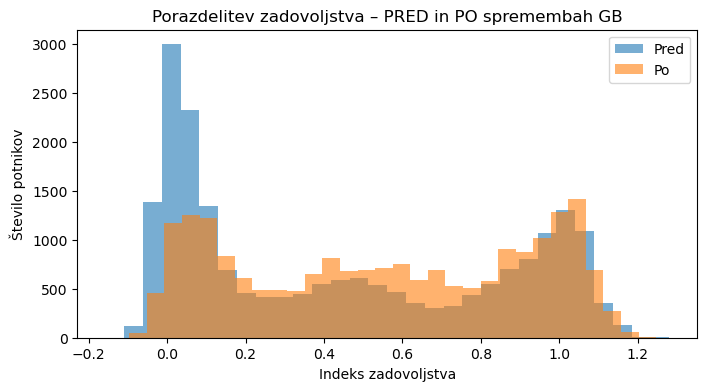

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(y_pred_before_GB, bins=30, alpha=0.6, label='Pred')
plt.hist(y_pred_after_GB, bins=30, alpha=0.6, label='Po')
plt.xlabel("Indeks zadovoljstva")
plt.ylabel("Število potnikov")
plt.title("Porazdelitev zadovoljstva – PRED in PO spremembah GB")
plt.legend()
plt.show()

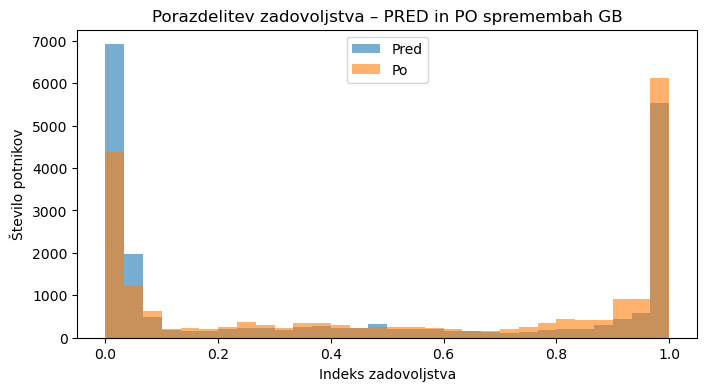

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(y_pred_before_RF, bins=30, alpha=0.6, label='Pred')
plt.hist(y_pred_after_RF, bins=30, alpha=0.6, label='Po')
plt.xlabel("Indeks zadovoljstva")
plt.ylabel("Število potnikov")
plt.title("Porazdelitev zadovoljstva – PRED in PO spremembah GB")
plt.legend()
plt.show()

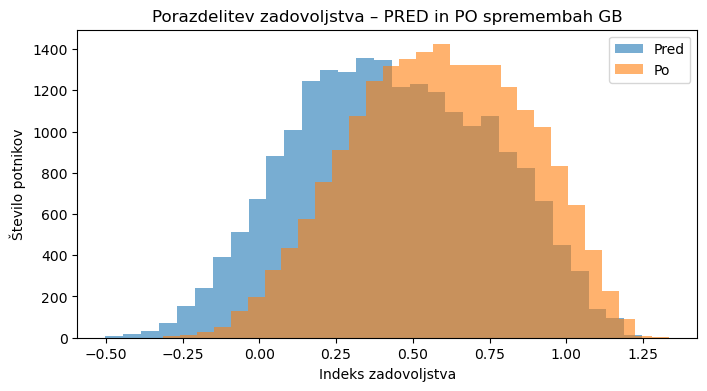

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(y_pred_before_R, bins=30, alpha=0.6, label='Pred')
plt.hist(y_pred_after_R, bins=30, alpha=0.6, label='Po')
plt.xlabel("Indeks zadovoljstva")
plt.ylabel("Število potnikov")
plt.title("Porazdelitev zadovoljstva – PRED in PO spremembah GB")
plt.legend()
plt.show()

## Six Sigma analiza

In [ ]:
tolerance = 0.25

errors_before_GB = np.abs(y_test - y_pred_before_GB)
errors_after_GB = np.abs(y_test - y_pred_after_GB)

errors_before_RF = np.abs(y_test - y_pred_before_RF)
errors_after_RF = np.abs(y_test - y_pred_after_RF)

errors_before_R = np.abs(y_test - y_pred_before_R)
errors_after_R = np.abs(y_test - y_pred_after_R)


In [ ]:
threshold = 0.5

# DPMO PREJ: Koliko jih je pod pragom v originalnem stanju
dpmo_before_GB = (y_pred_before_GB < threshold).mean() * 1_000_000

# DPMO POTEM: Koliko jih je pod pragom po tvojih izboljšavah (sedeži + zamude)
dpmo_after_GB = (y_pred_after_GB < threshold).mean() * 1_000_000

dpmo_before_RF = (y_pred_before_RF < threshold).mean() * 1_000_000
dpmo_after_RF = (y_pred_after_RF < threshold).mean() * 1_000_000

dpmo_before_R = (y_pred_before_R < threshold).mean() * 1_000_000
dpmo_after_R = (y_pred_after_R < threshold).mean() * 1_000_000

In [ ]:
from scipy.stats import norm

def dpmo_to_sigma(dpmo):
    return norm.ppf(1 - dpmo / 1_000_000) + 1.5

sigma_before_GB = dpmo_to_sigma(dpmo_before_GB)
sigma_after_GB = dpmo_to_sigma(dpmo_after_GB)

sigma_before_RF = dpmo_to_sigma(dpmo_before_RF)
sigma_after_RF = dpmo_to_sigma(dpmo_after_RF)

sigma_before_R = dpmo_to_sigma(dpmo_before_R)
sigma_after_R = dpmo_to_sigma(dpmo_after_R)



In [ ]:
sigma_df = pd.DataFrame({
    'DPMO PREJ': [dpmo_before_GB, dpmo_before_RF, dpmo_before_R],
    'Sigma PREJ': [sigma_before_GB, sigma_before_RF, sigma_before_R],
    'DPMO POTEM': [dpmo_after_GB, dpmo_after_RF, dpmo_after_R],
    'Sigma POTEM': [sigma_after_GB, sigma_after_RF, sigma_after_R],
    'Izboljšava σ': [sigma_after_GB - sigma_before_GB, sigma_after_RF - sigma_before_RF, sigma_after_R - sigma_before_R]
})

sigma_df


,DPMO PREJ,Sigma PREJ,DPMO POTEM,Sigma POTEM,Izboljšava σ
0,585631.105337,1.283679,454357.345652,1.614660,0.330981
1,579086.665704,1.300442,456089.697320,1.610290,0.309847
2,575766.325008,1.308926,391222.751552,1.776134,0.467208


# 8. Končni povzetek

V okviru seminarske naloge je bila izvedena celovita podatkovna analiza zadovoljstva letalskih potnikov z namenom boljšega razumevanja dejavnikov, ki vplivajo na zaznano kakovost storitev, ter razvoja napovednega modela za podporo odločanju in optimizacijo procesa.

Osrednji problem analize je bil prepoznati ključne dejavnike zadovoljstva ter kvantitativno oceniti učinek sprememb v procesu. Razvitih je bilo več napovednih modelov (linearna regresija, Ridge, Lasso, Random Forest, Gradient Boosting). Najboljši rezultat je dosegel model Random Forest (R² ≈ 0.77, MAE ≈ 0.12, RMSE ≈ 0.236), kar pomeni visoko pojasnjeno varianco in dobro napovedno moč. Gradient Boosting je dosegel nekoliko slabše, a še vedno zelo dobre rezultate.

Analiza pomembnosti spremenljivk in simulacije so pokazale, da imajo največji vpliv na zadovoljstvo predvsem dejavniki, povezani s kakovostjo storitve (npr. splošna kakovost storitve, prijaznost osebja, udobje in organizacija procesa). Simulacije so pokazale, da izboljšanje teh dejavnikov vodi do opaznega povečanja napovedanega zadovoljstva.

Globalna simulacija sprememb je pokazala povečanje povprečnega indeksa zadovoljstva iz 0.436 na 0.555, kar predstavlja približno 27 % relativno izboljšanje. To kaže na pomemben praktični učinek predlaganih ukrepov.

Six Sigma analiza je pokazala znižanje sigma stopnje z 1.65 na 1.24. Ta rezultat je v nasprotju z regresijskimi rezultati in simulacijami ter najverjetneje izhaja iz metodoloških omejitev (npr. definicija tolerance pri regresijskem problemu). Zato Six Sigma metriko v tem primeru interpretiramo previdno.

Na podlagi vseh rezultatov priporočamo implementacijo izboljšav, osredotočenih na ključne dejavnike kakovosti storitev, ter uporabo napovednega modela kot orodja za podporo odločanju in testiranje scenarijev pred uvedbo sprememb v praksi.
